In [64]:
%load_ext autoreload
%autoreload 2
import torch
import imageio
import sys
import io
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
sys.path.append("../radialmri/")
from simulation_and_reconstruction import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Malignant Case

dict_keys(['__header__', '__version__', '__globals__', 'ID', 'S0', 'aif', 'cts', 'mask', 'parMap', 'simImg', 'smap_complex'])


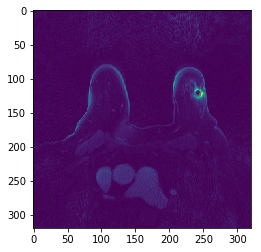

In [2]:
filedir = '/gpfs/home/zh1115/knolllabspace/hzn/storage/newsimulation/simulated_20210128/sim_BC33'
dataload = loadmat(filedir)
print(dataload.keys())

plt.imshow(np.abs(dataload['simImg'][:, :, 9]))
plt.show()

In [3]:
masksloaded = dataload['mask']

simulated_image = dataload['simImg']
simulated_image = np.flipud(np.array(simulated_image))#flip up and down

simulated_target = np.array(simulated_image, dtype='complex128')
simulated_target = simulated_target.swapaxes(0, 2).swapaxes(1, 2)
#print(simulated_target.shape, simulated_target.dtype)

target = np.stack((simulated_target.real, simulated_target.imag), axis=1)
target = torch.tensor(target, dtype=dtype, device=device)

smap_complex = dataload['smap_complex']
smap_loaded = numpy2torch(smap_complex, device =device)
smap_loaded = smap_loaded.permute(1,0,2,3).unsqueeze(0)

nt = 22
temporal_coilimg = np.array([sim_coil(simulated_target[i,:,:], smap_complex, coild=0) for i in range(nt)])

target_recombine= np.array([temporal_coilimg[:,i]*np.conj(smap_complex[i,:,:]) for i in range(temporal_coilimg.shape[1])])
target_recombine= np.sum(target_recombine, axis=0)

print("target.shape", target.shape, target.dtype,\
      "smap.shape", smap_loaded.shape, smap_loaded.dtype)

simulated_kspace_21, recon_fromsim_21, traj_21, dcomp_21 \
= RadialSimulation(target = target,
                   spokespertime=21,
                   nt=nt, nc=16,
                   spokelength=640,
                   smap=smap_loaded,
                   grid_size = (640, 640),
                   im_size= (320, 320))

recon_fromsim_21 = torch2numpy(recon_fromsim_21.permute(0,2,3,1))

target.shape torch.Size([22, 2, 320, 320]) torch.float32 smap.shape torch.Size([1, 16, 2, 320, 320]) torch.float32
torch.Size([22, 16, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


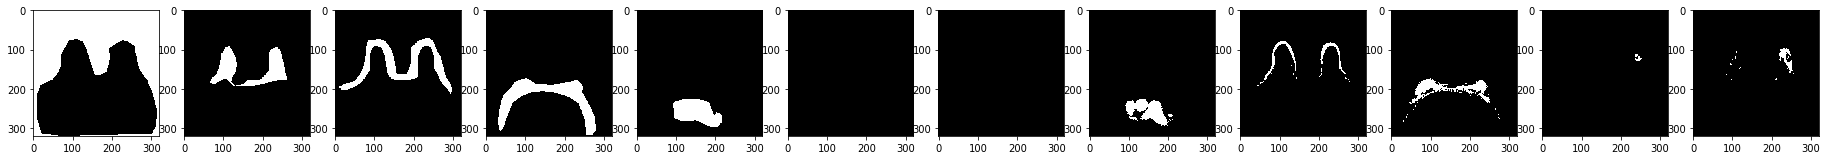

In [4]:
plotcoil(masksloaded[0][0], n = 12, cmap = 'gray')

In [5]:
simulated_kspace_cartesian, recon_fromsim_cartesian = CartesianSimulation(target = target, smap=smap_loaded)

recon_fromsim_cartesian = torch2numpy(recon_fromsim_cartesian.squeeze().permute(0,2,3,1))

torch.Size([16, 22, 320, 320, 2])
torch.Size([22, 2, 320, 320])


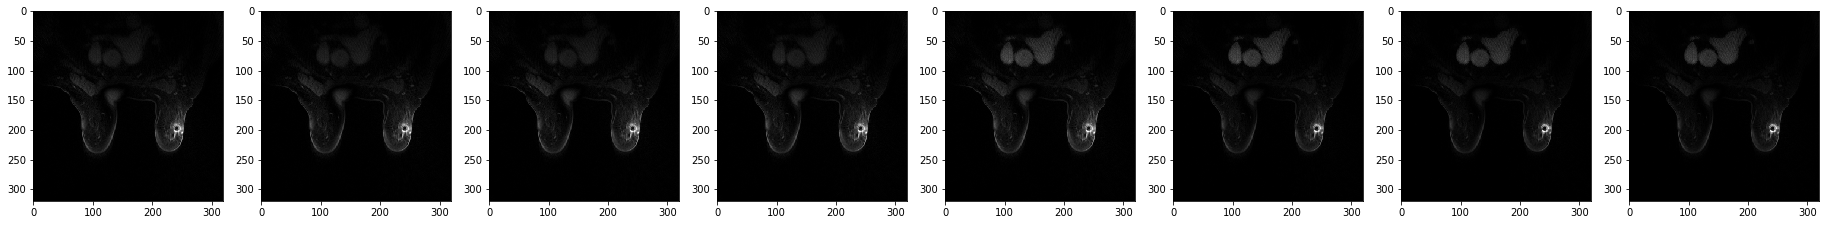

In [6]:
plotcoil(x = np.abs(recon_fromsim_cartesian))

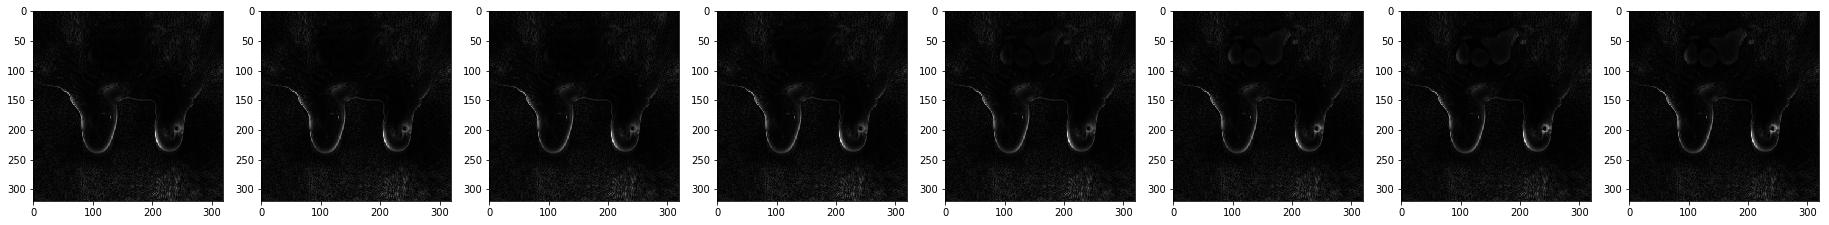

In [8]:
target_numpy = torch2numpy(target, complexdim= 1)

plotcoil(x = np.abs(recon_fromsim_cartesian - target_numpy))

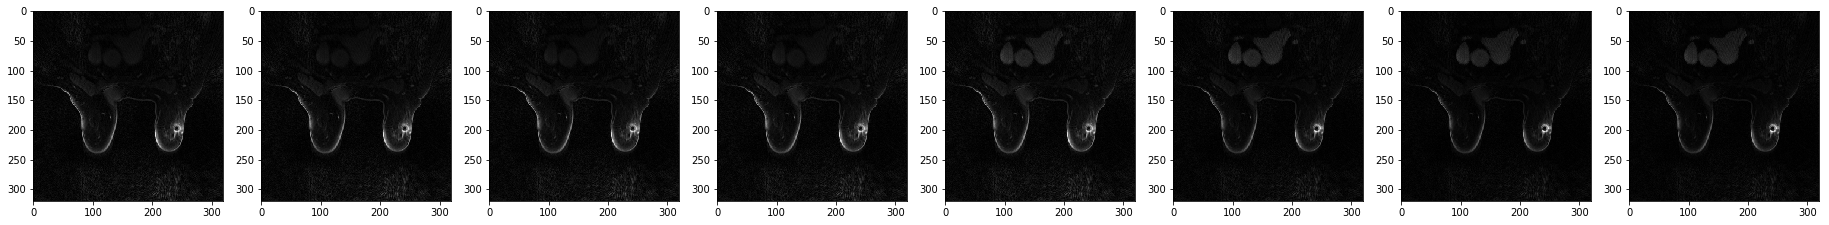

In [9]:
plotcoil(x = np.abs(target_numpy))

(22,)


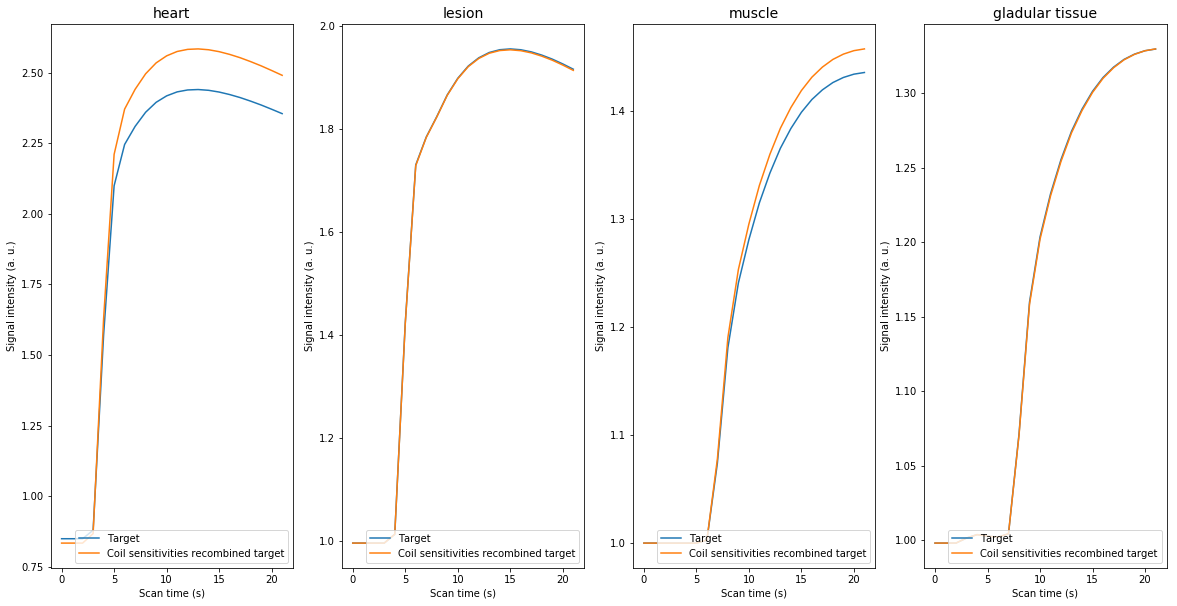

In [55]:
plotcurves(x_hat = target_recombine[:,::-1,:],#np.abs(recon_fromsim_cartesian[:,::-1,:]), 
           #x_gt =  
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Coil sensitivities recombined target', 'Target'], 
           normalize = True)

(22,)


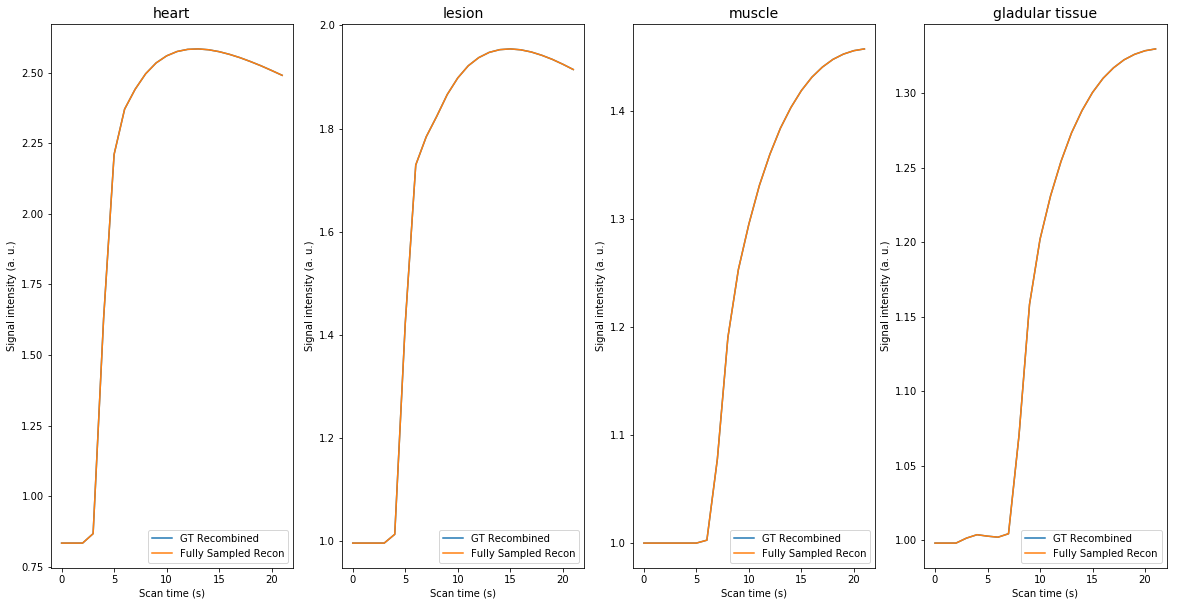

In [12]:
plotcurves(x_hat = np.abs(recon_fromsim_cartesian[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy, 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT Recombined'], 
           normalize = True)

(22,)


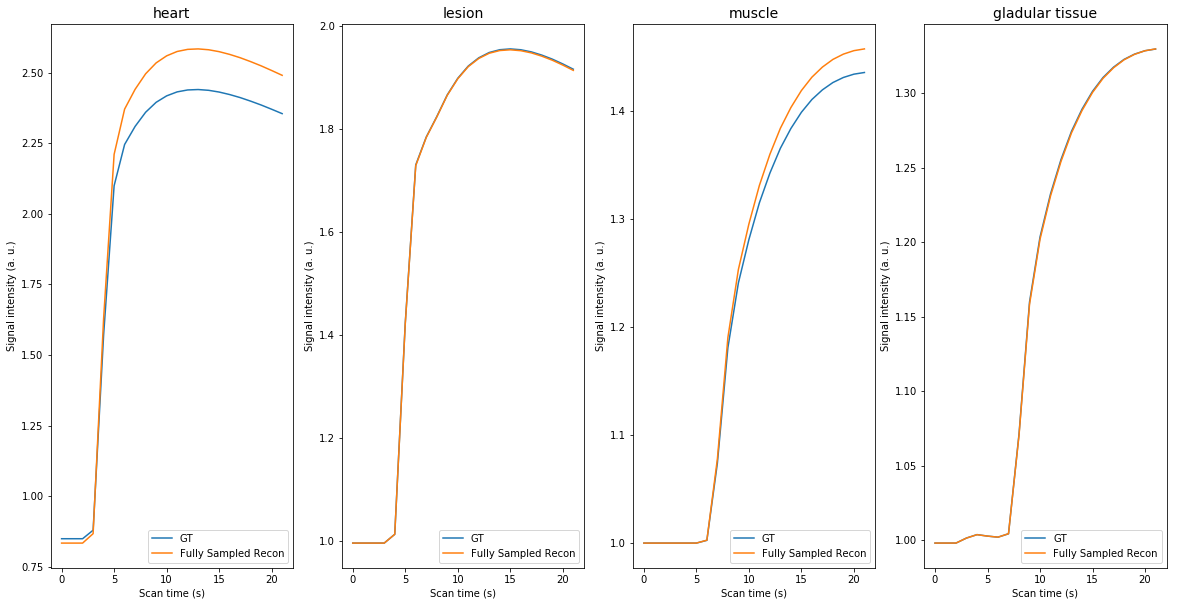

In [13]:
plotcurves(x_hat = np.abs(recon_fromsim_cartesian[:,::-1,:]), 
           x_gt = target_numpy[:,::-1,:], 
           #x_gt = target_numpy, 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

### Under-sampling, 16 lines in the center, 4 times under-sampling outside center

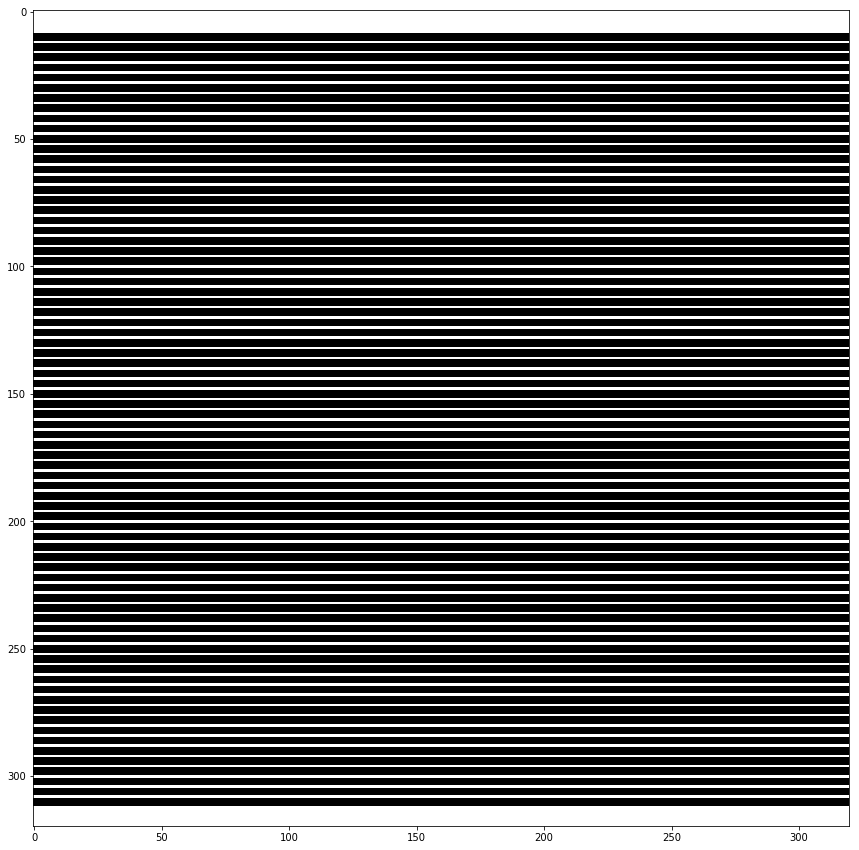

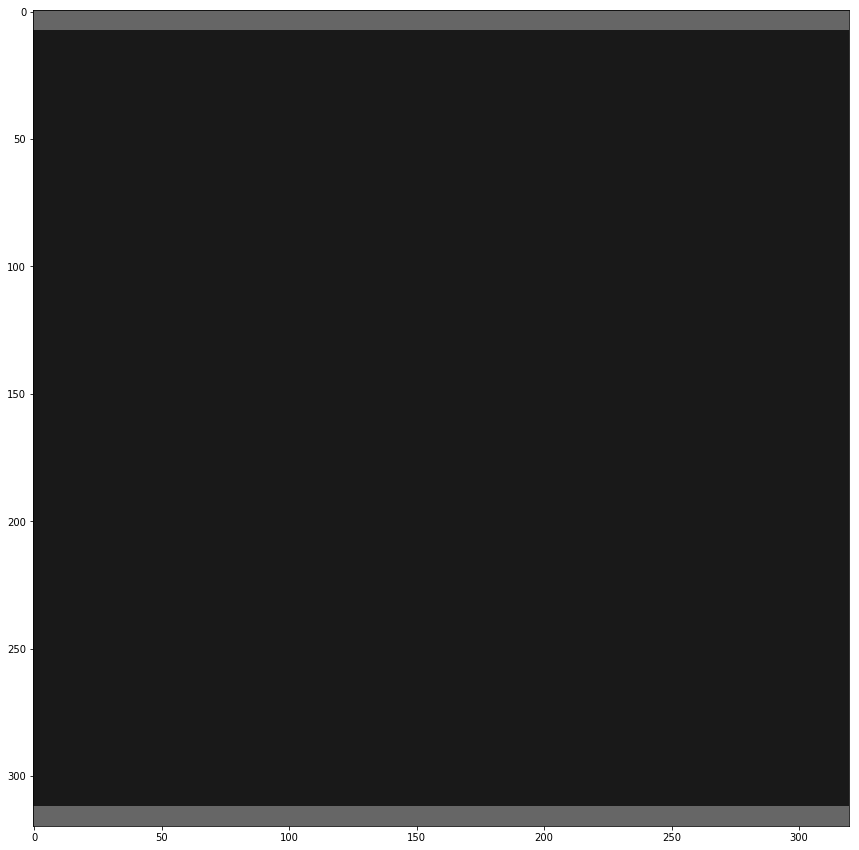

In [39]:
def mask_undersample(imsize, centerlines, rate):
    assert len(imsize) == 2
    assert imsize[0] % 2 == 0 and imsize[1] % 2 == 0 and centerlines % 2 == 0
    
    res = torch.zeros(imsize)
    density = torch.ones(imsize)
    res[::rate] = 1
    res[imsize[0] // 2 - centerlines // 2 : imsize[1] // 2 + centerlines // 2] = 1
    density[imsize[0] // 2 - centerlines // 2 : imsize[1] // 2 + centerlines // 2] = rate
    
    #if ifshift:
    #    res = torch.flip(res, dims = (0, 1))
    
    return res, density

cartesian_usmask, density = mask_undersample((320, 320), 16, 4)
cartesian_usmask = torch.tensor(np.fft.fftshift(cartesian_usmask.cpu().numpy(), axes = (0, 1))).to(device)

density = torch.tensor(np.fft.fftshift(density.cpu().numpy(), axes = (0, 1))).to(device)

cartesian_usmask.shape
plt.figure(figsize = (15, 15))
plt.imshow(cartesian_usmask.cpu())
plt.show()

plt.figure(figsize = (15, 15))
plt.imshow(density.cpu(), vmax=10, vmin=0)
plt.show()

torch.Size([16, 22, 320, 320, 2])


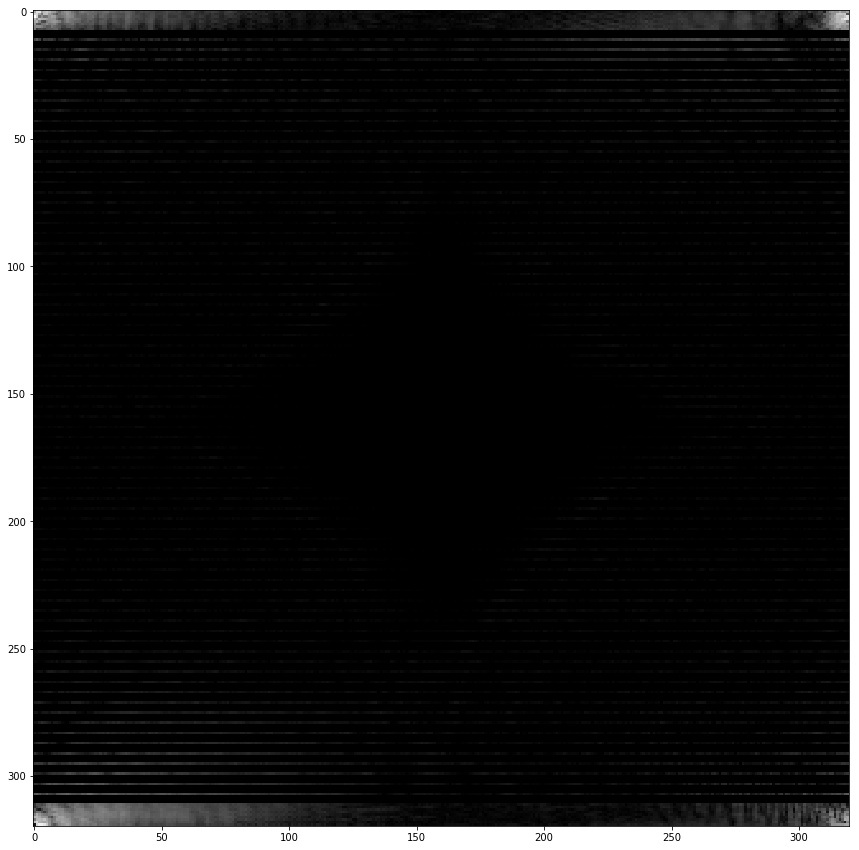

In [15]:
simulated_kspace_cartesian_4x = simulated_kspace_cartesian * cartesian_usmask.reshape((1, 1, 320, 320, 1)).to(device)
print(simulated_kspace_cartesian_4x.shape)

plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_4x)[0, 0])))
plt.show()

### Zero-filled reconstruction, Cartesian, no density compensation

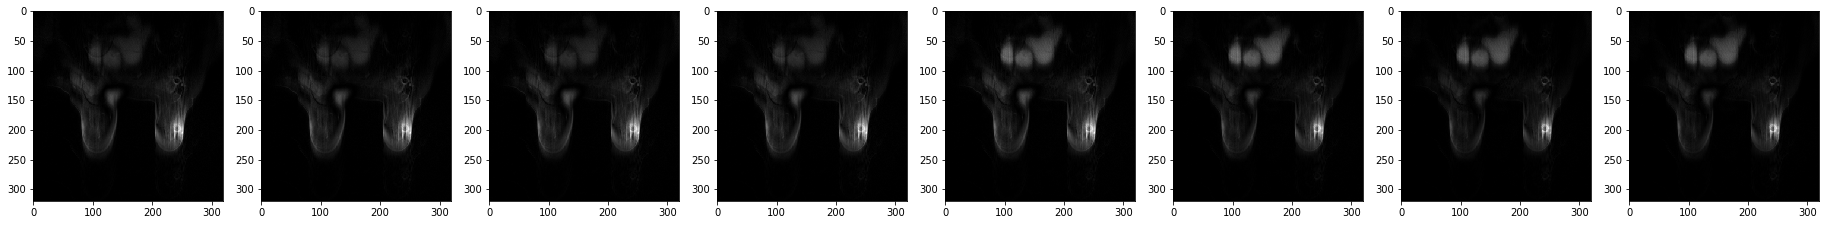

(22, 320, 320)


In [16]:
Cartesian_model = CartesianModel()

zerofilled = Cartesian_model.backward(y = simulated_kspace_cartesian_4x, coil_sensitivities= smap_loaded)

zerofilled = torch2numpy(zerofilled.squeeze(), complexdim=1)

plotcoil(zerofilled)

print(zerofilled.shape)

(22,)


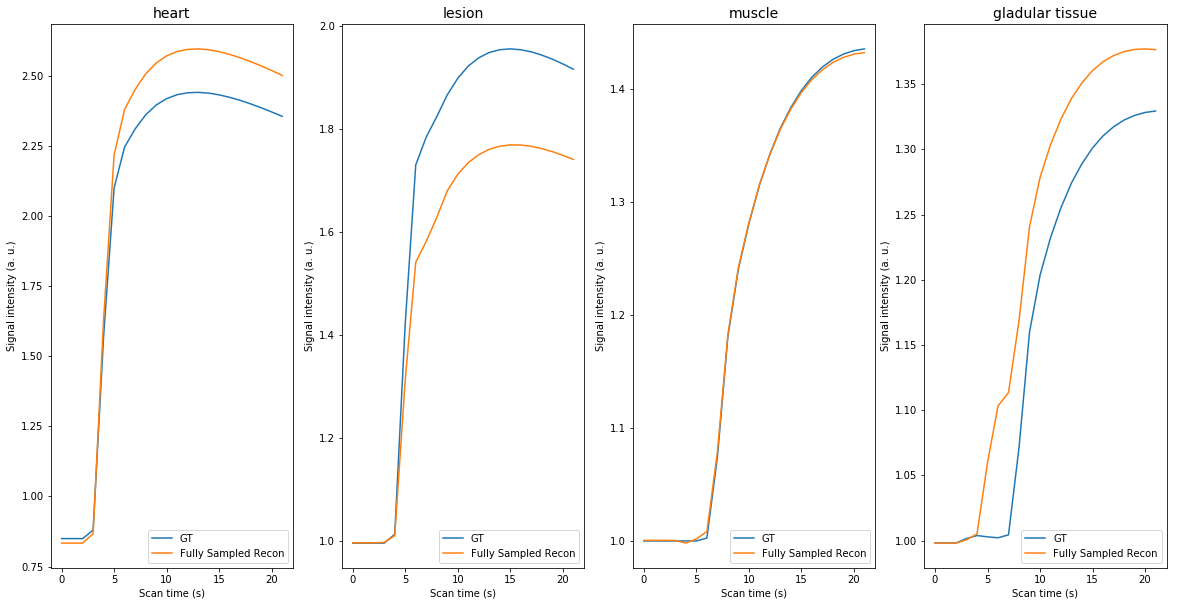

In [17]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

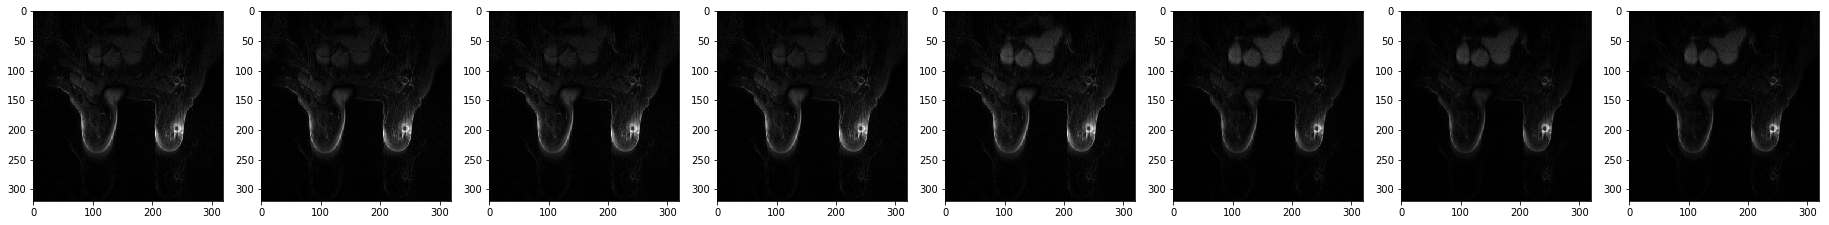

(22,)


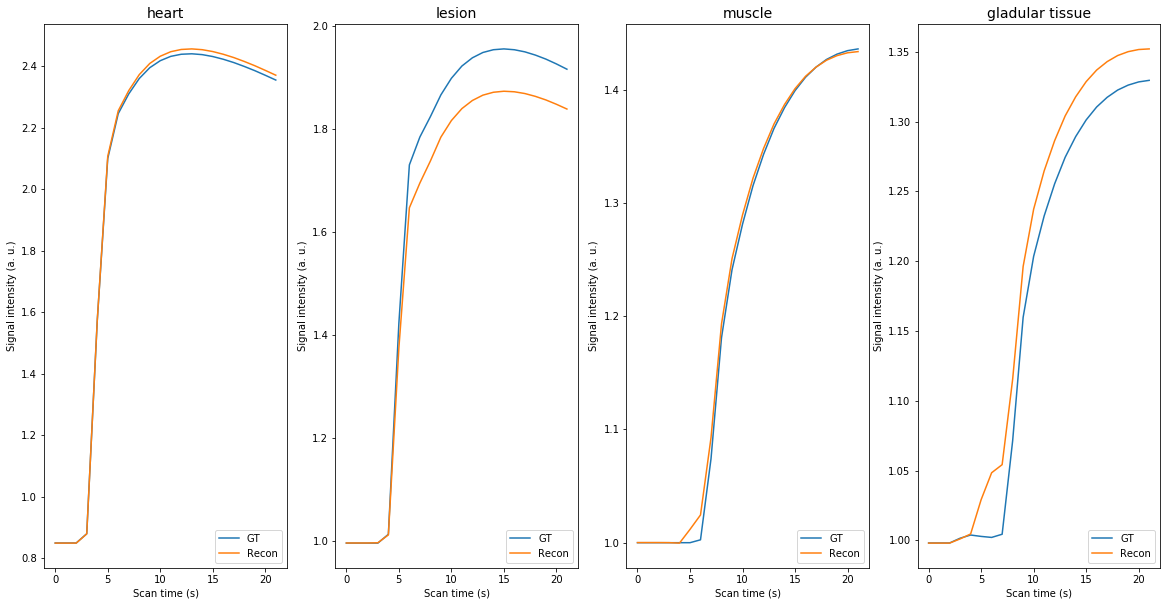

In [20]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'GD', niter = 24)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

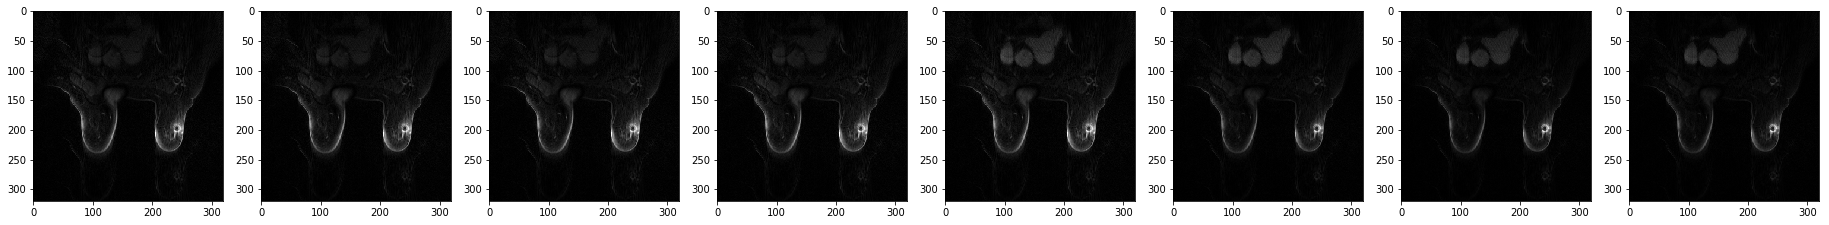

(22,)


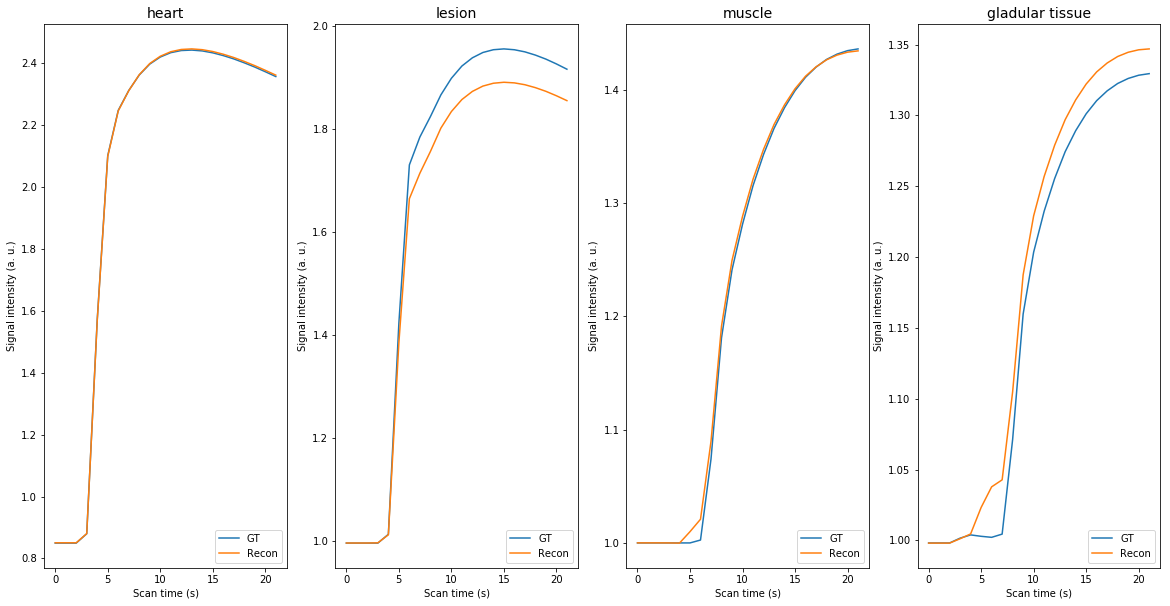

In [21]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'GD', niter = 128)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

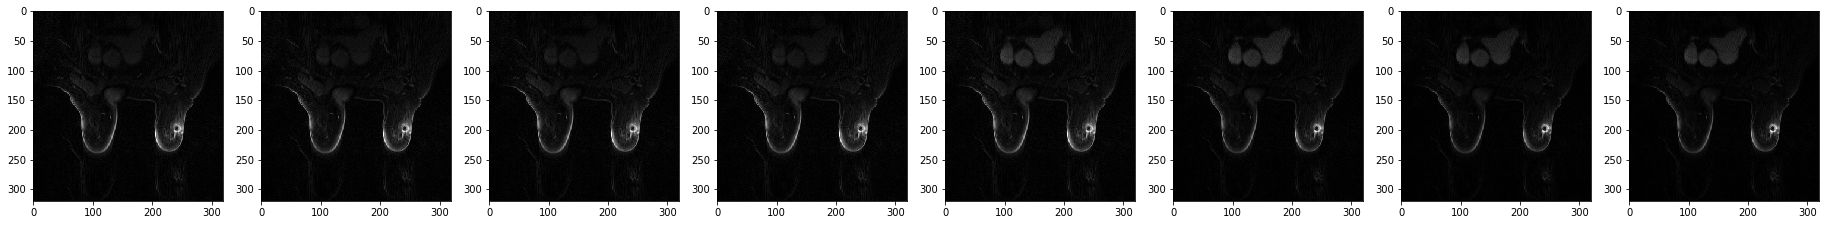

(22,)


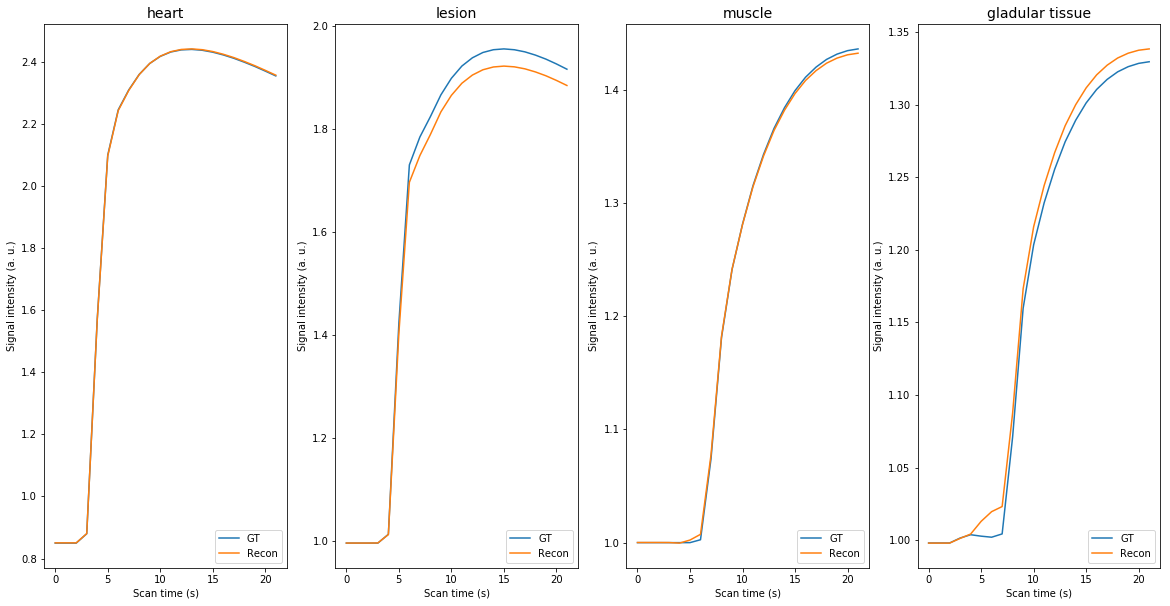

In [22]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'GD', niter = 640)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

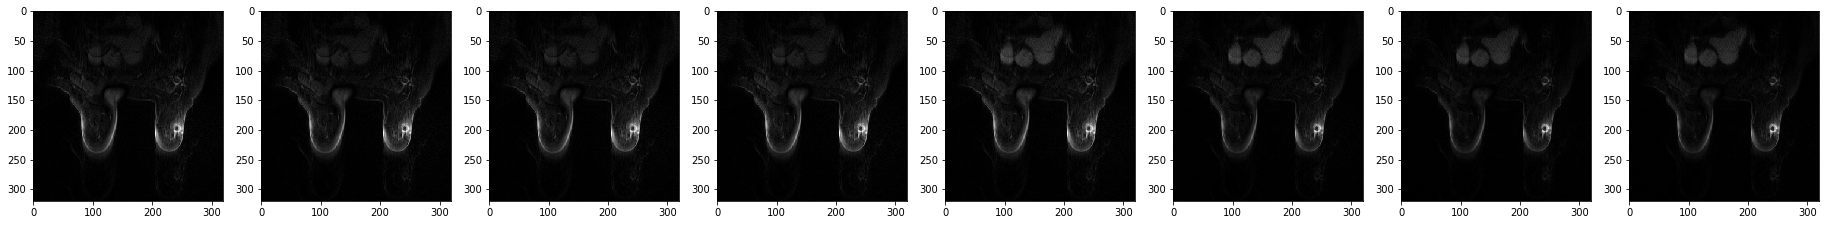

(22,)


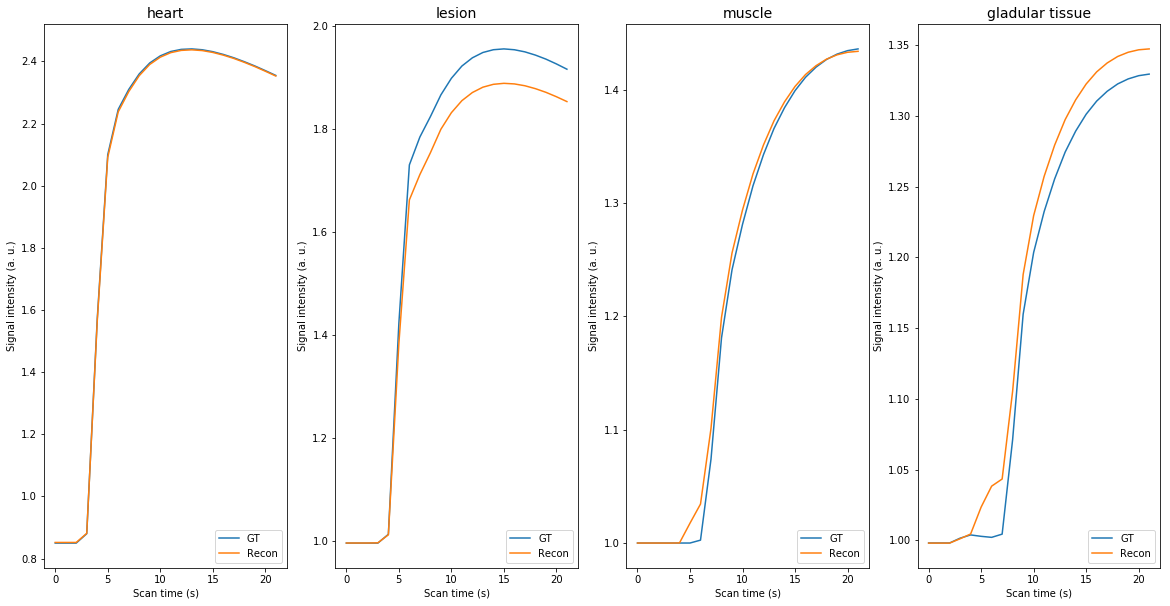

In [31]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 3, verbose = False)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

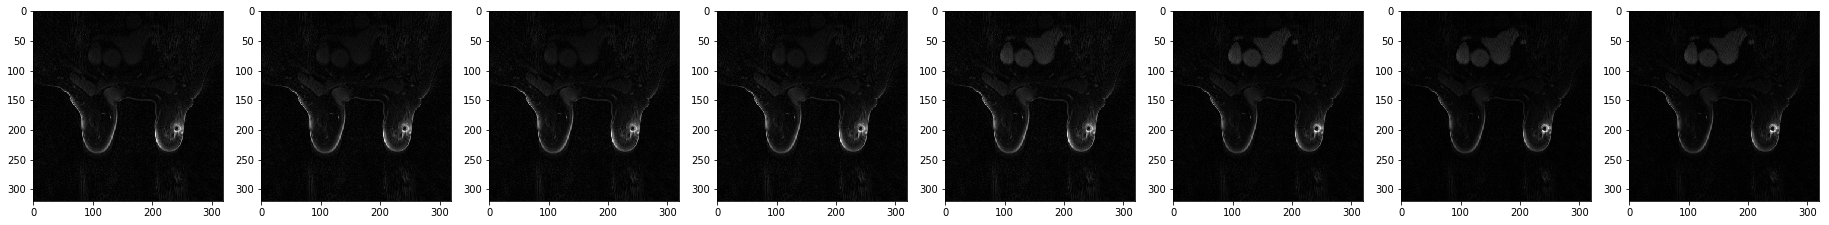

(22,)


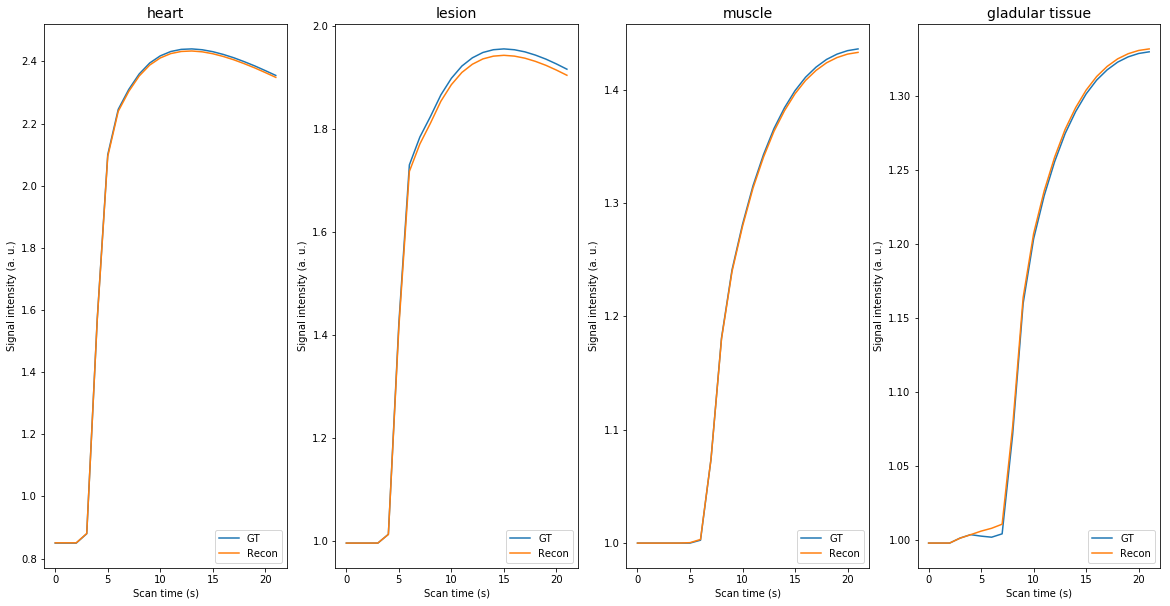

In [29]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 24, verbose = False)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

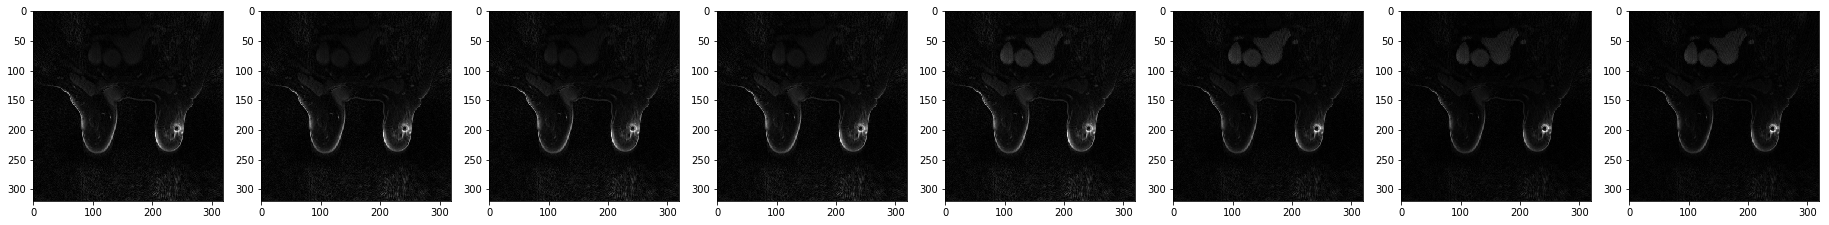

(22,)


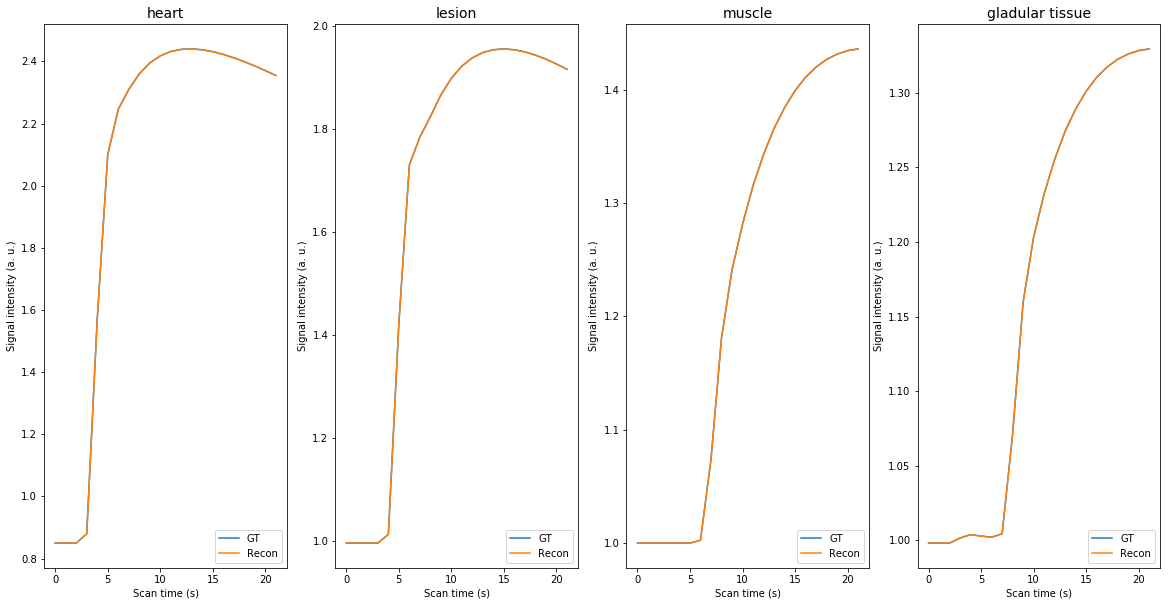

In [30]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 128, verbose = False)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

## Zero-filled reconstruction, Cartesian, with density compensation

In [48]:
print(simulated_kspace_cartesian_4x.shape, density.shape)

torch.Size([16, 22, 320, 320, 2]) torch.Size([320, 320])


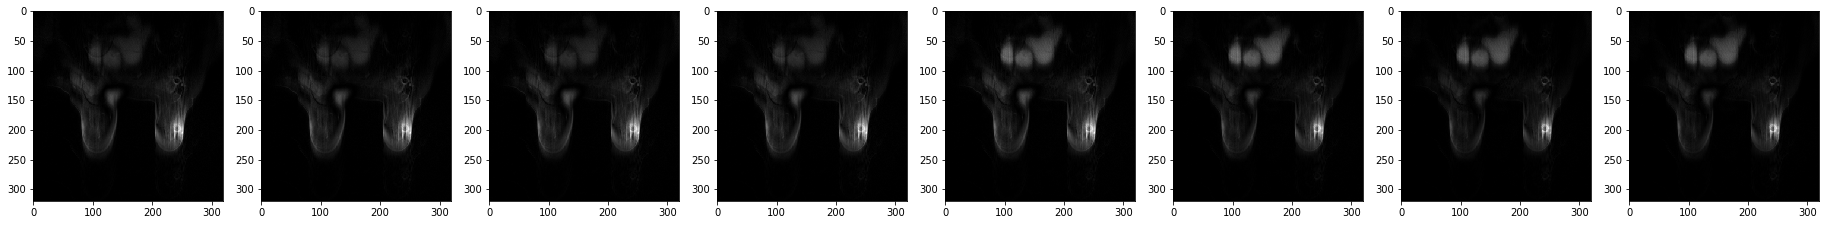

(22, 320, 320)


In [49]:
Cartesian_model = CartesianModel()

zerofilled = Cartesian_model.backward(y= simulated_kspace_cartesian_4x , coil_sensitivities= smap_loaded)
zerofilled = torch2numpy(zerofilled.squeeze(), complexdim= 1)

plotcoil(zerofilled)

print(zerofilled.shape)

(22,)


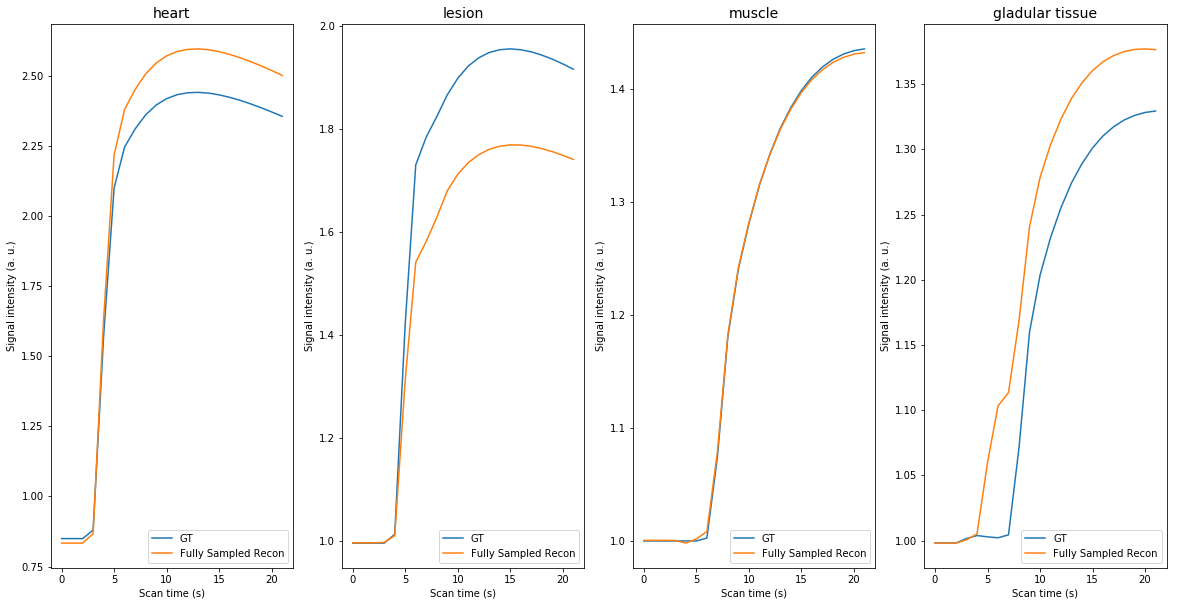

In [50]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

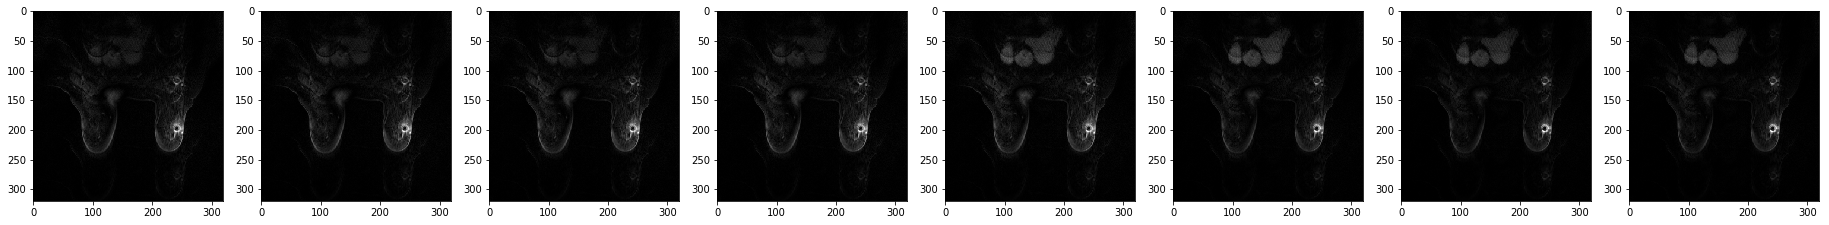

(22, 320, 320)


In [46]:
Cartesian_model = CartesianModel()

zerofilled = Cartesian_model.backward(y= simulated_kspace_cartesian_4x / density.reshape((1, 1, 320, 320, 1)).to(device), coil_sensitivities= smap_loaded)
zerofilled = torch2numpy(zerofilled.squeeze(), complexdim= 1)

plotcoil(zerofilled)

print(zerofilled.shape)

(22,)


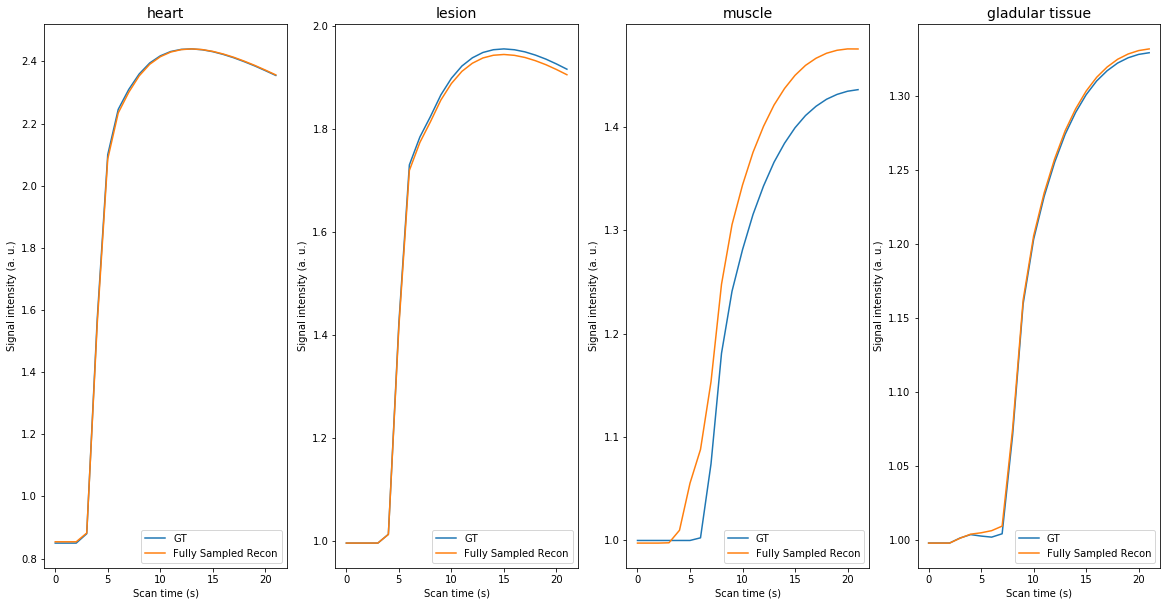

In [47]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

../radialmri/simulation_and_reconstruction.py:23: UserWarning: Out of sync with the remove repository
  warnings.warn('Out of sync with the remove repository')


(22,)


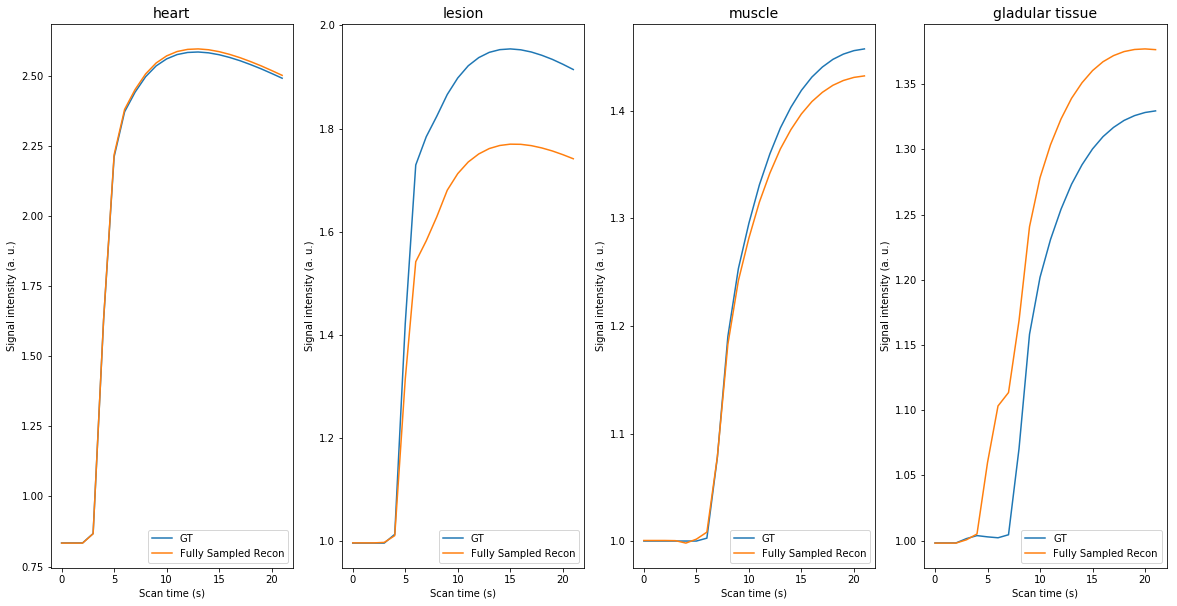

In [51]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

### Under-sampling, 8 lines in the center, 8 times under-sampling outside center

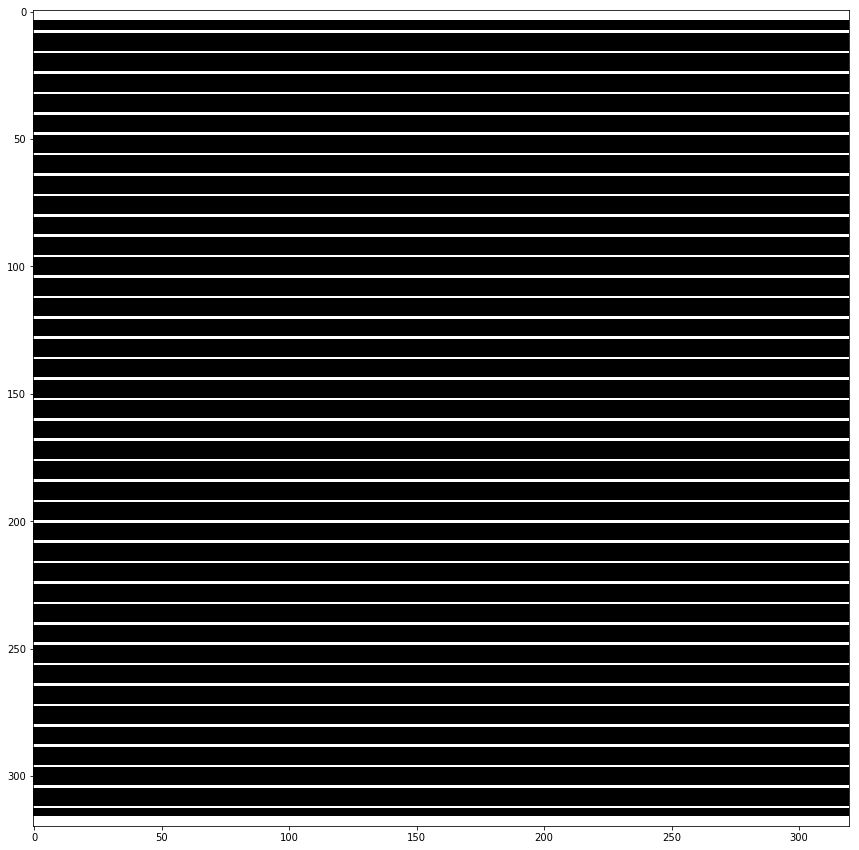

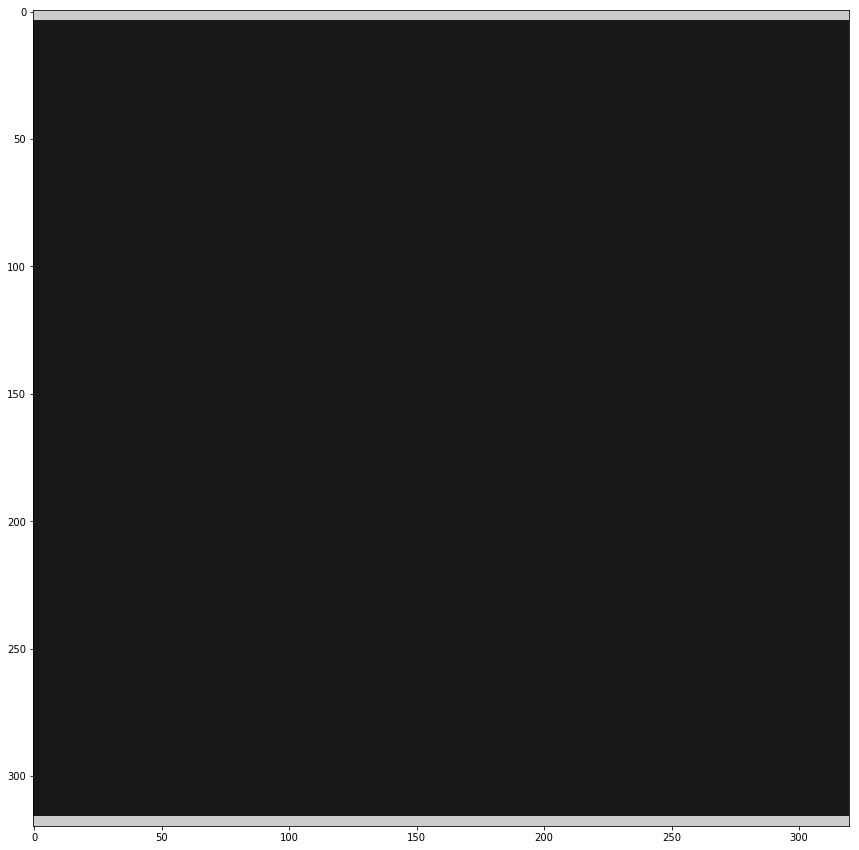

In [66]:
cartesian_usmask_8x, density_8x = mask_undersample((320, 320), 8, 8)
cartesian_usmask_8x = torch.tensor(np.fft.fftshift(cartesian_usmask_8x.cpu().numpy(), axes = (0, 1))).to(device)

density_8x = torch.tensor(np.fft.fftshift(density_8x.cpu().numpy(), axes = (0, 1))).to(device)

cartesian_usmask_8x.shape
plt.figure(figsize = (15, 15))
plt.imshow(cartesian_usmask_8x.cpu())
plt.show()

plt.figure(figsize = (15, 15))
plt.imshow(density_8x.cpu(), vmax=10, vmin=0)
plt.show()

torch.Size([16, 22, 320, 320, 2])


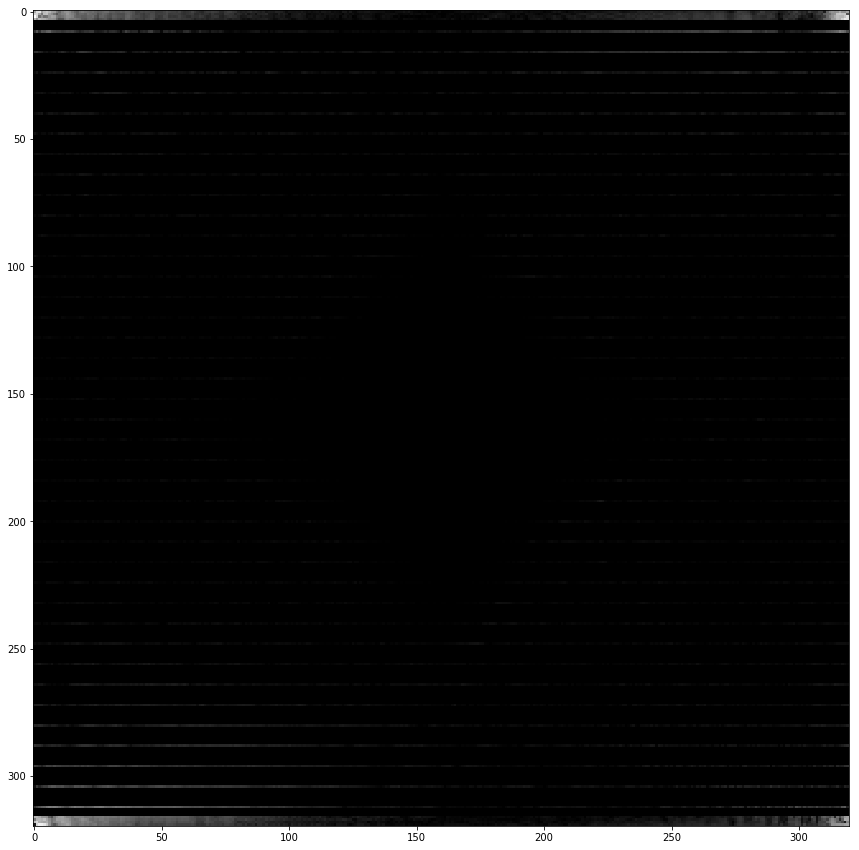

In [69]:
simulated_kspace_cartesian_8x = simulated_kspace_cartesian * cartesian_usmask_8x.reshape((1, 1, 320, 320, 1)).to(device)
print(simulated_kspace_cartesian_8x.shape)

plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_8x)[0, 0])))
plt.show()

In [70]:
density_8x[:6]

tensor([[8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

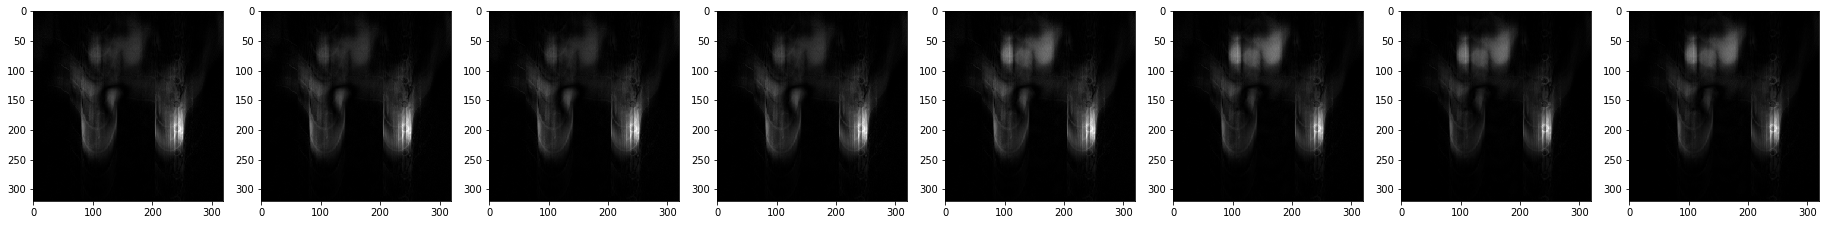

(22, 320, 320)


In [71]:
Cartesian_model = CartesianModel()
zerofilled_8x = Cartesian_model.backward(y= simulated_kspace_cartesian_8x , coil_sensitivities= smap_loaded)
zerofilled_8x = torch2numpy(zerofilled_8x.squeeze(), complexdim= 1)

plotcoil(zerofilled_8x)

print(zerofilled_8x.shape)

(22,)


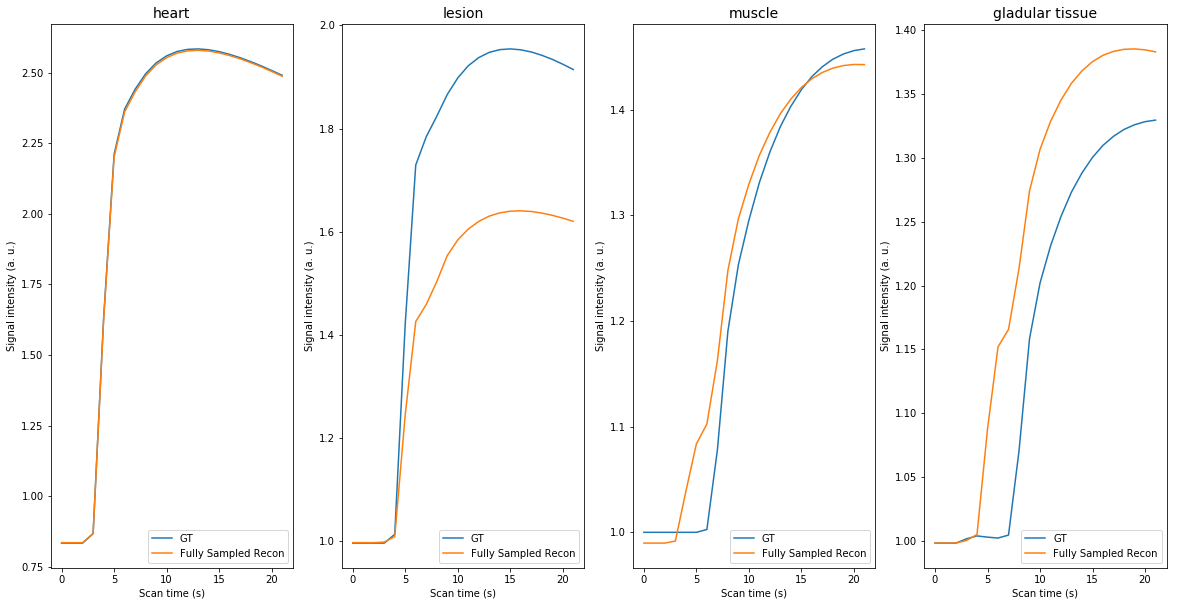

In [74]:
plotcurves(x_hat = np.abs(zerofilled_8x[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

(22,)


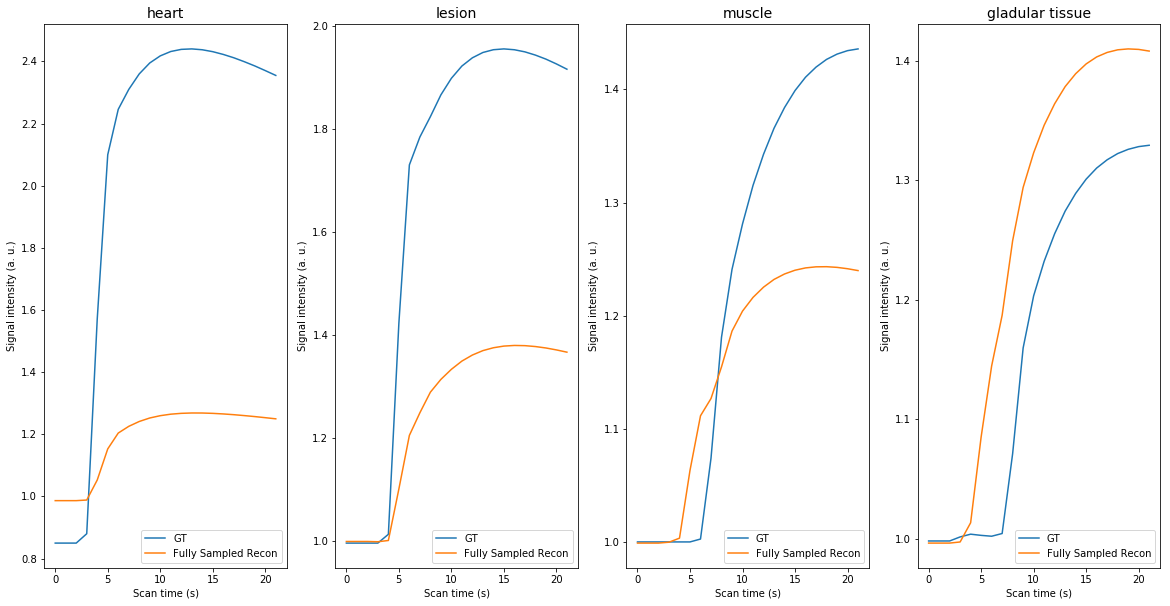

In [81]:
plotcurves(x_hat = np.abs(zerofilled_8x[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

### Add density compensation

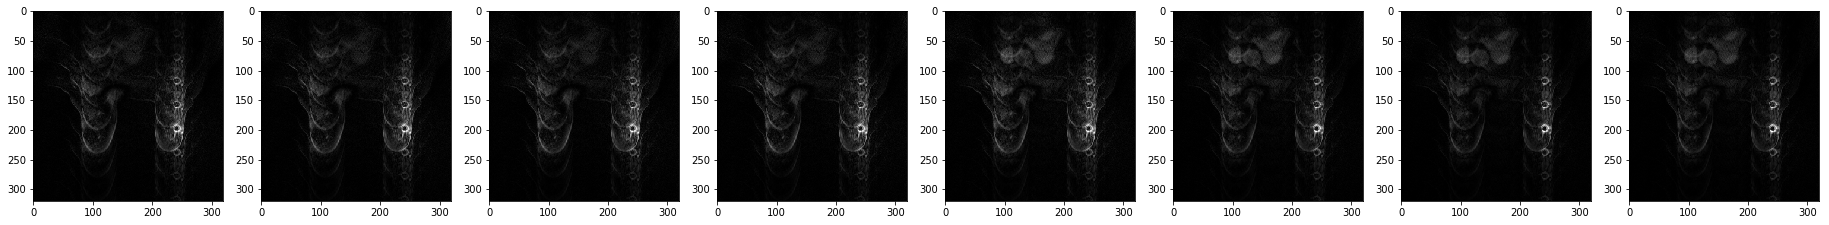

(22, 320, 320)


In [75]:
Cartesian_model = CartesianModel()
zerofilled_8x = Cartesian_model.backward(y= simulated_kspace_cartesian_8x / density_8x.reshape((1, 1, 320, 320, 1)).to(device), coil_sensitivities= smap_loaded)
zerofilled_8x = torch2numpy(zerofilled_8x.squeeze(), complexdim= 1)

plotcoil(zerofilled_8x)

print(zerofilled_8x.shape)


(22,)


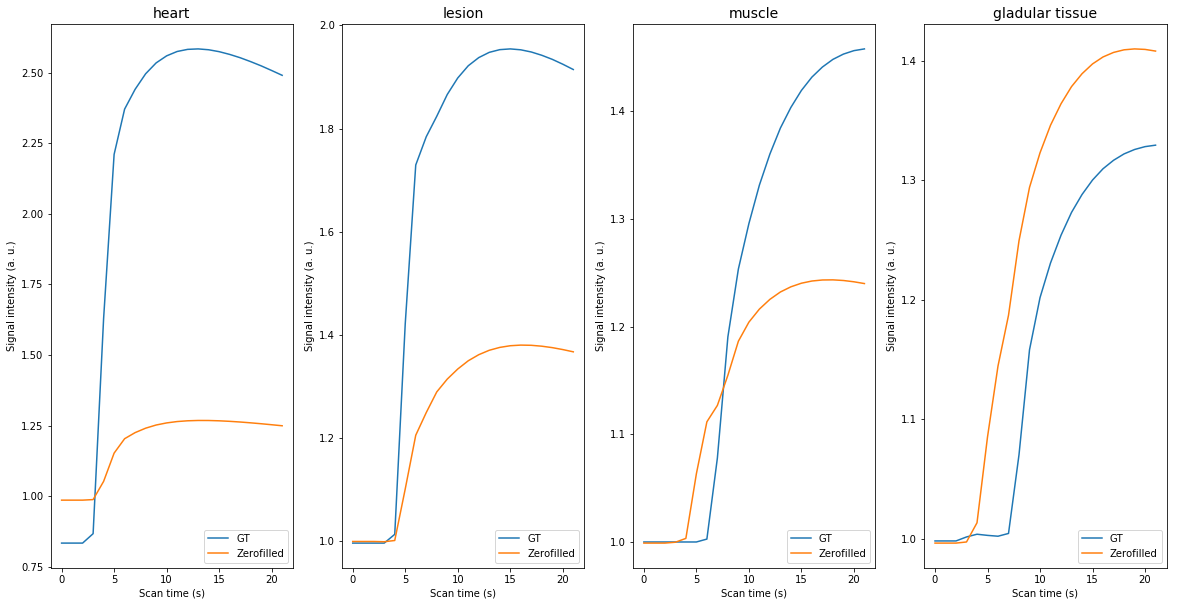

In [88]:
plotcurves(x_hat = np.abs(zerofilled_8x[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Zerofilled', 'GT'], 
           normalize = True)

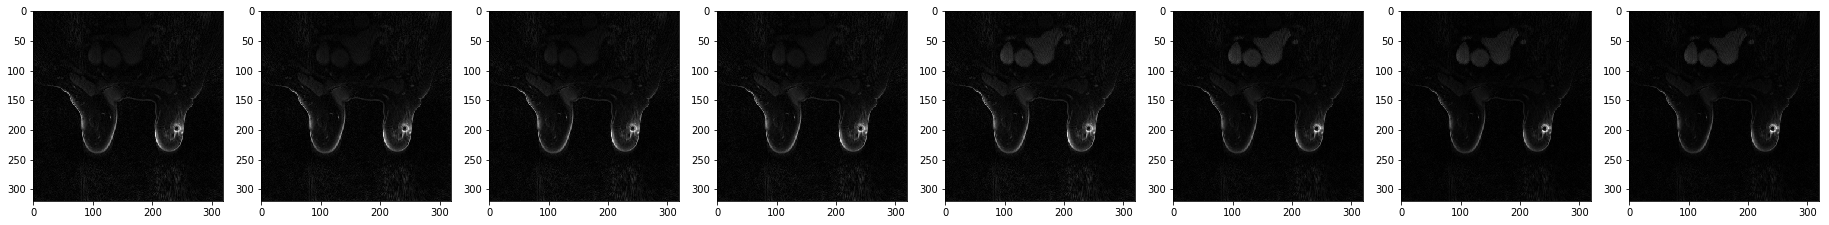

(22,)


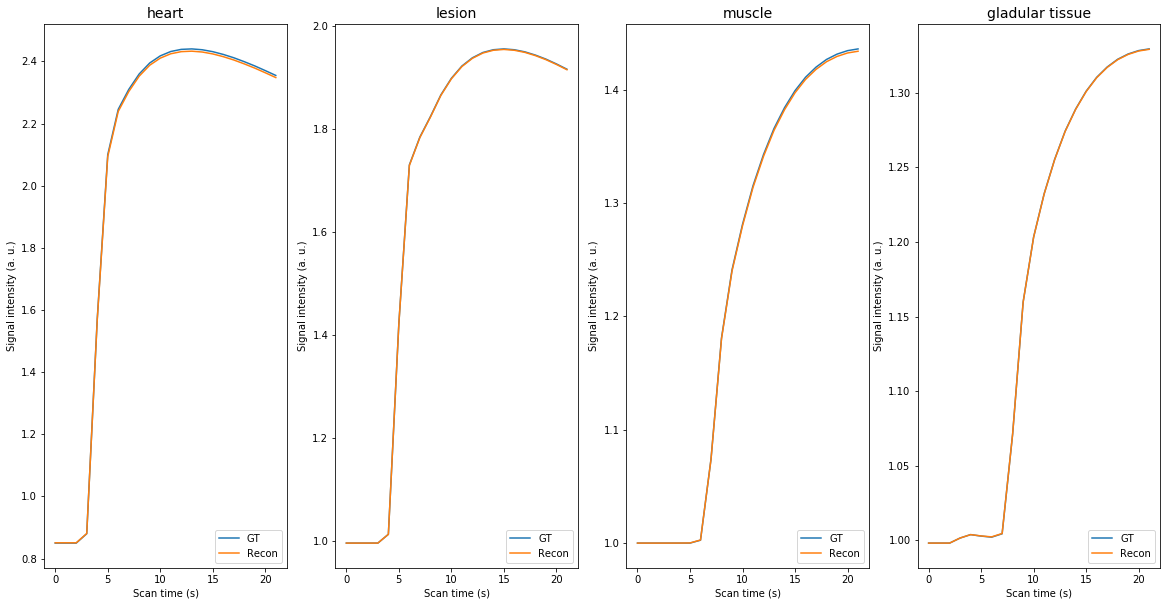

In [79]:
cartesian_recon_8x, zerofilled_8x = CartesianRecon(kspace= simulated_kspace_cartesian_8x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask_8x.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 128, verbose = False)

plotcoil(torch2numpy(cartesian_recon_8x, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon_8x, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

### More Undersampling, 16 x

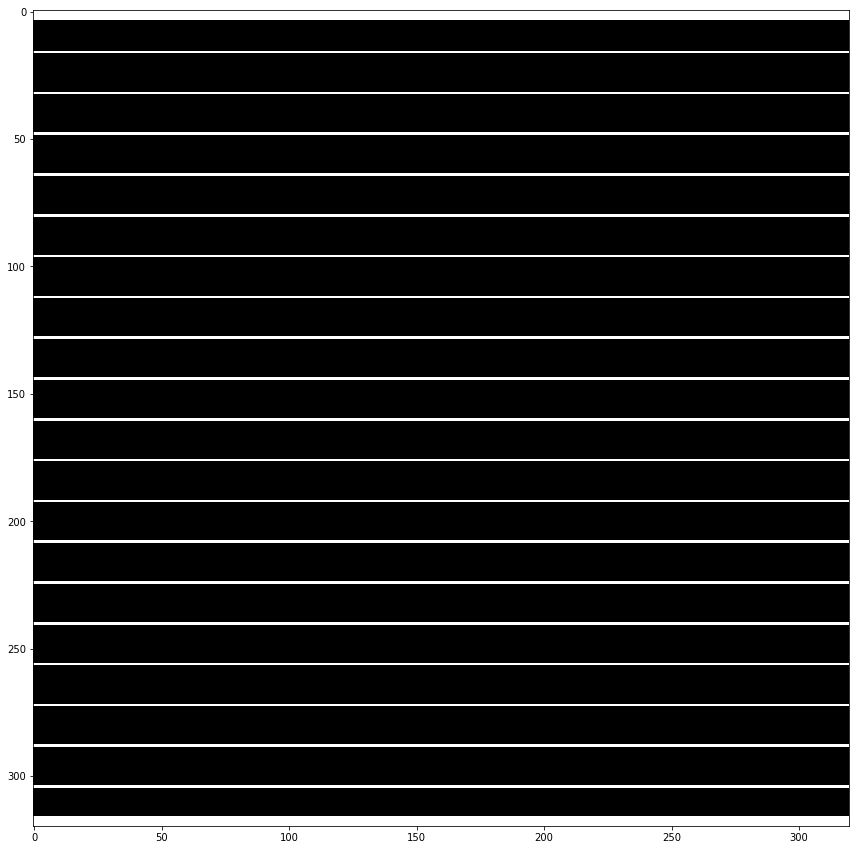

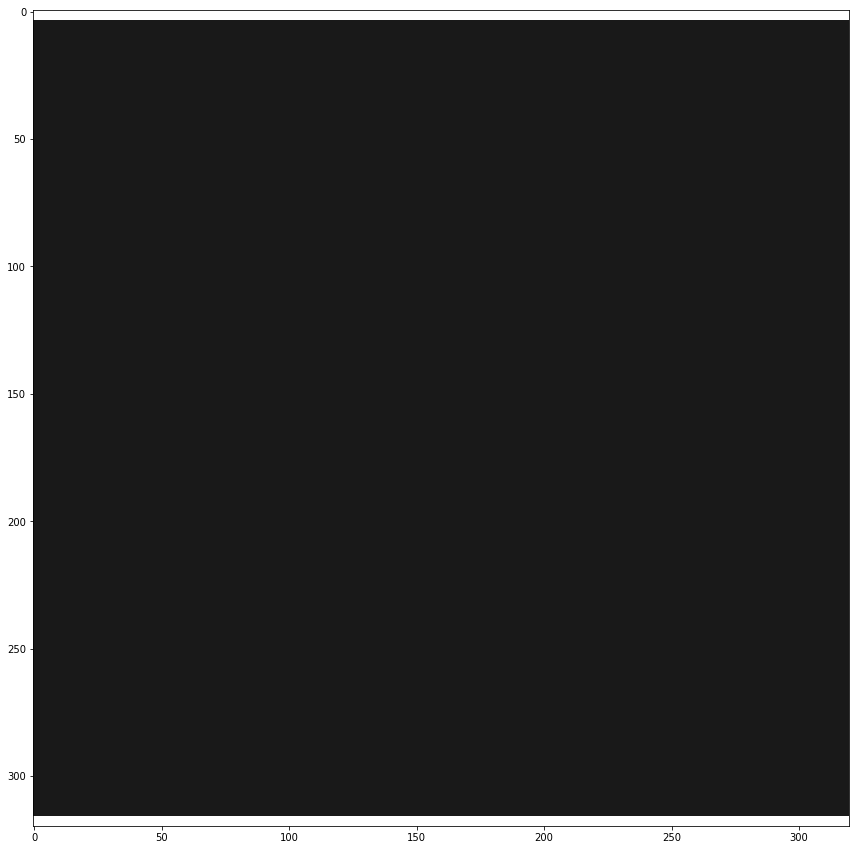

In [80]:
cartesian_usmask_x, density_x = mask_undersample((320, 320), 8, 16)
cartesian_usmask_x = torch.tensor(np.fft.fftshift(cartesian_usmask_x.cpu().numpy(), axes = (0, 1))).to(device)

density_x = torch.tensor(np.fft.fftshift(density_x.cpu().numpy(), axes = (0, 1))).to(device)

cartesian_usmask_x.shape
plt.figure(figsize = (15, 15))
plt.imshow(cartesian_usmask_x.cpu())
plt.show()

plt.figure(figsize = (15, 15))
plt.imshow(density_x.cpu(), vmax=10, vmin=0)
plt.show()

torch.Size([16, 22, 320, 320, 2])


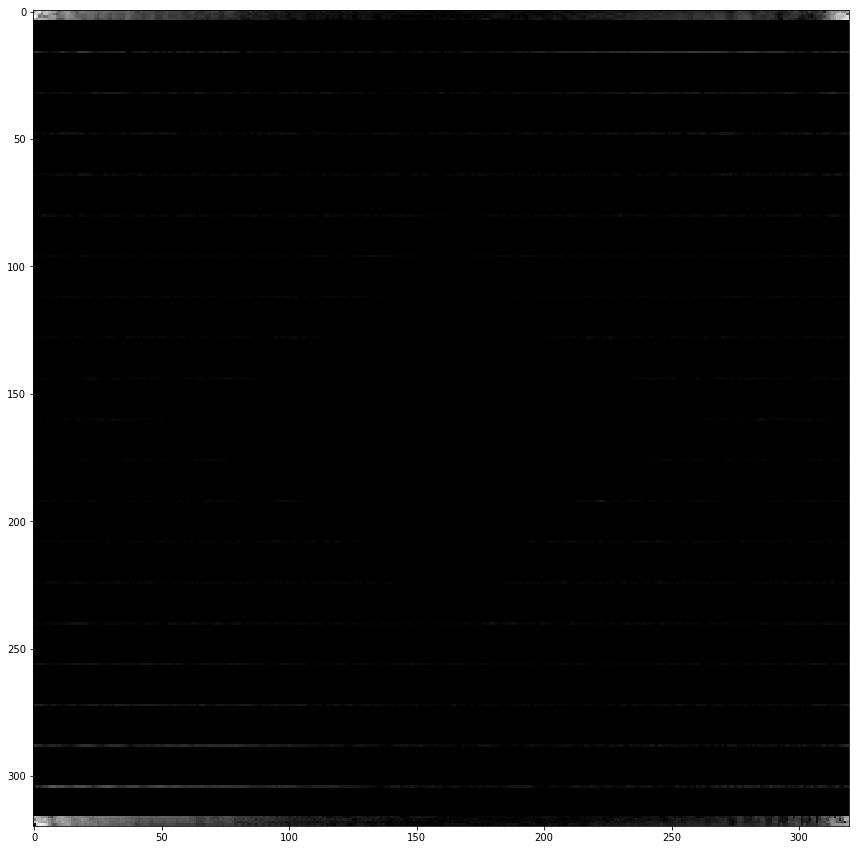

In [83]:
simulated_kspace_cartesian_x = simulated_kspace_cartesian * cartesian_usmask_x.reshape((1, 1, 320, 320, 1)).to(device)
print(simulated_kspace_cartesian_x.shape)

plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_x)[0, 0])))
plt.show()

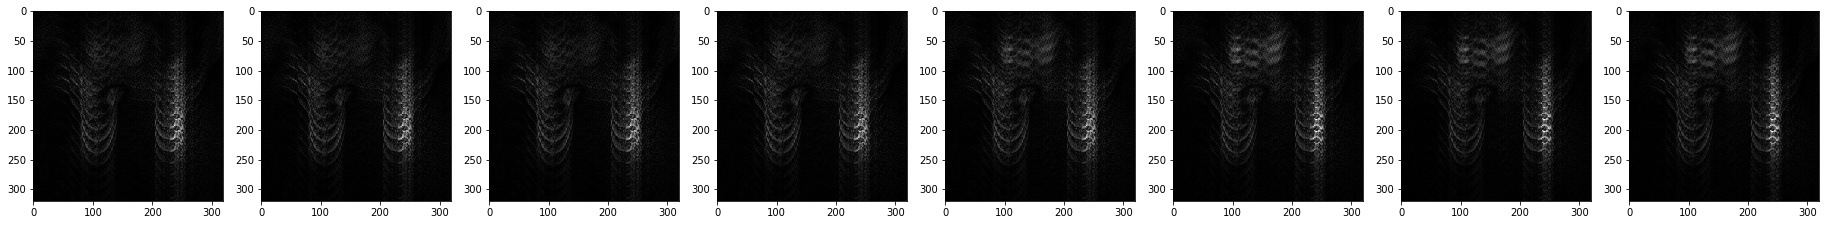

(22, 320, 320)


In [85]:
Cartesian_model = CartesianModel()
zerofilled_x = Cartesian_model.backward(y= simulated_kspace_cartesian_x / density_x.reshape((1, 1, 320, 320, 1)).to(device), coil_sensitivities= smap_loaded)
zerofilled_x = torch2numpy(zerofilled_x.squeeze(), complexdim= 1)

plotcoil(zerofilled_x)

print(zerofilled_x.shape)

(22,)


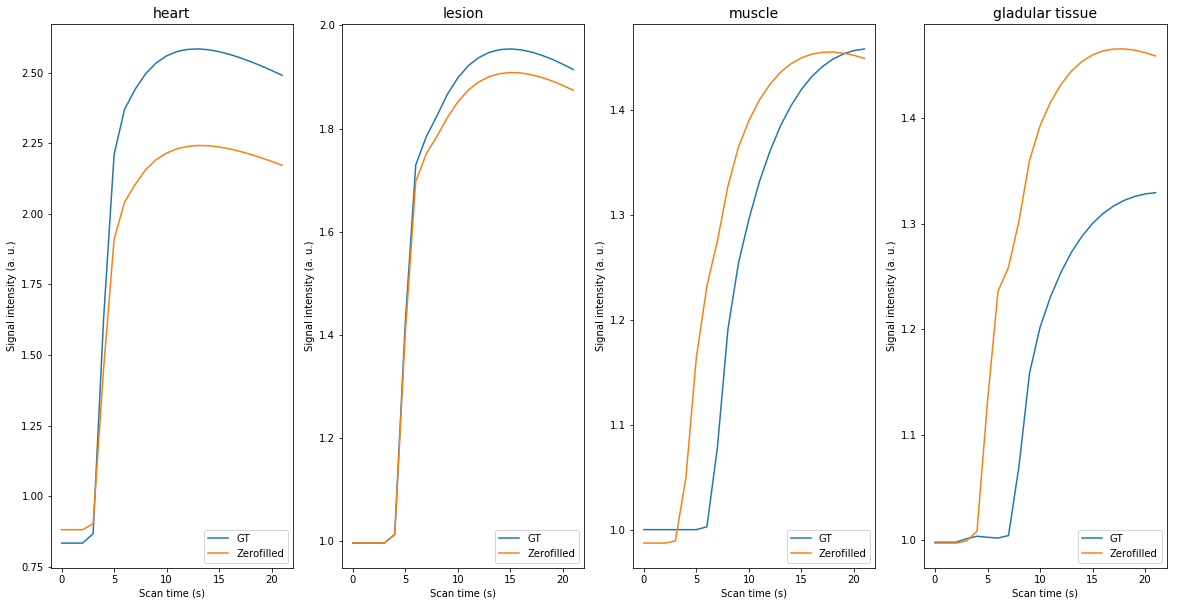

In [89]:
plotcurves(x_hat = np.abs(zerofilled_x[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Zerofilled', 'GT'], 
           normalize = True)

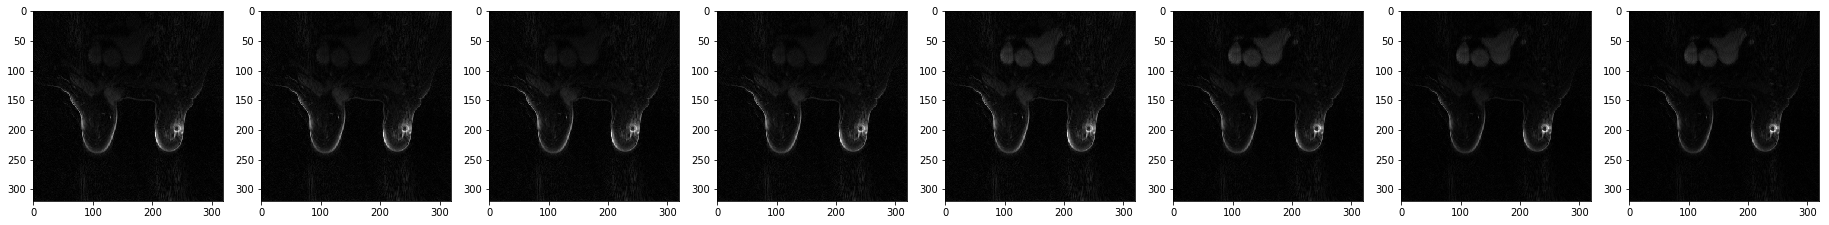

(22,)


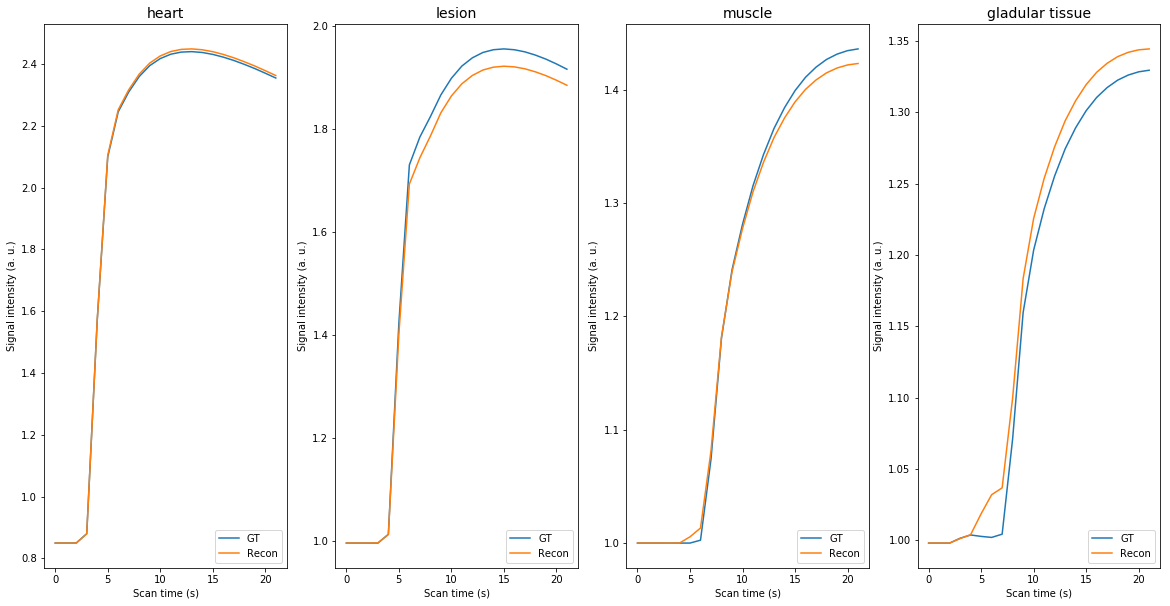

In [90]:
cartesian_recon_x, zerofilled_x = CartesianRecon(kspace= simulated_kspace_cartesian_x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask_x.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 128, verbose = False)

plotcoil(torch2numpy(cartesian_recon_x, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon_x, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

### Increase undersampling rate

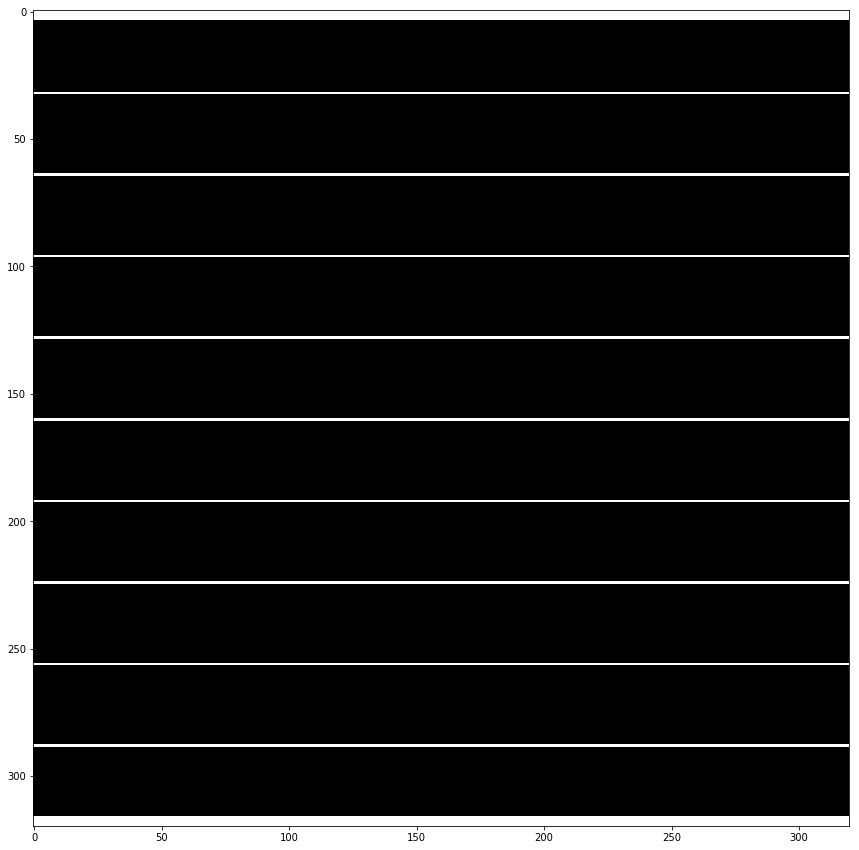

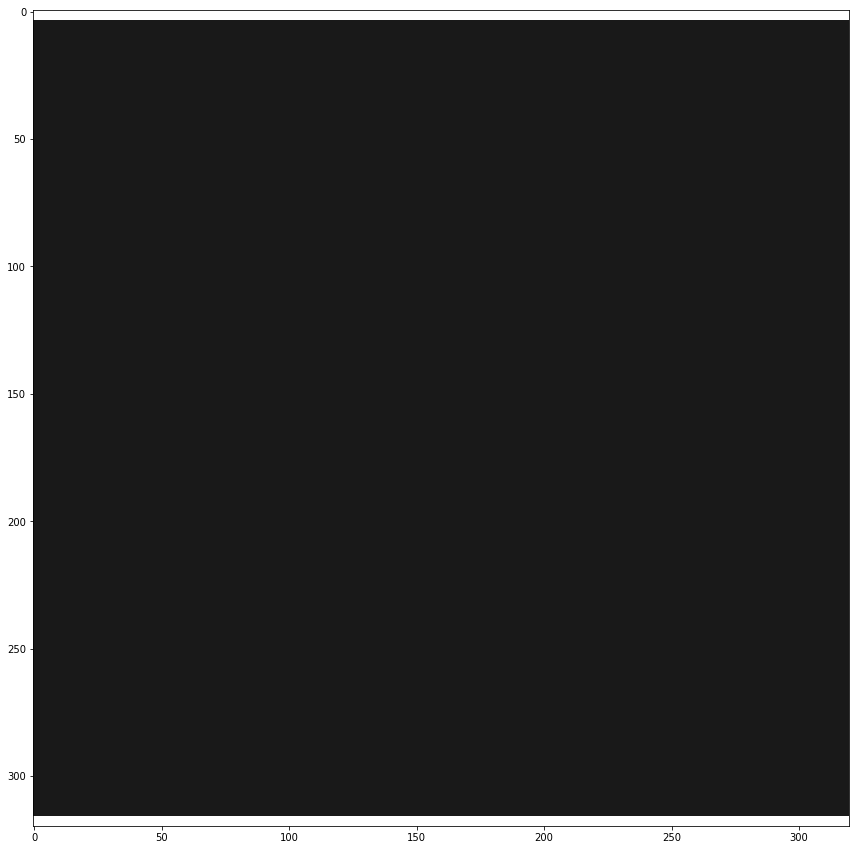

In [91]:
cartesian_usmask_x, density_x = mask_undersample((320, 320), 8, 32)
cartesian_usmask_x = torch.tensor(np.fft.fftshift(cartesian_usmask_x.cpu().numpy(), axes = (0, 1))).to(device)

density_x = torch.tensor(np.fft.fftshift(density_x.cpu().numpy(), axes = (0, 1))).to(device)

cartesian_usmask_x.shape
plt.figure(figsize = (15, 15))
plt.imshow(cartesian_usmask_x.cpu())
plt.show()

plt.figure(figsize = (15, 15))
plt.imshow(density_x.cpu(), vmax=10, vmin=0)
plt.show()

torch.Size([16, 22, 320, 320, 2])


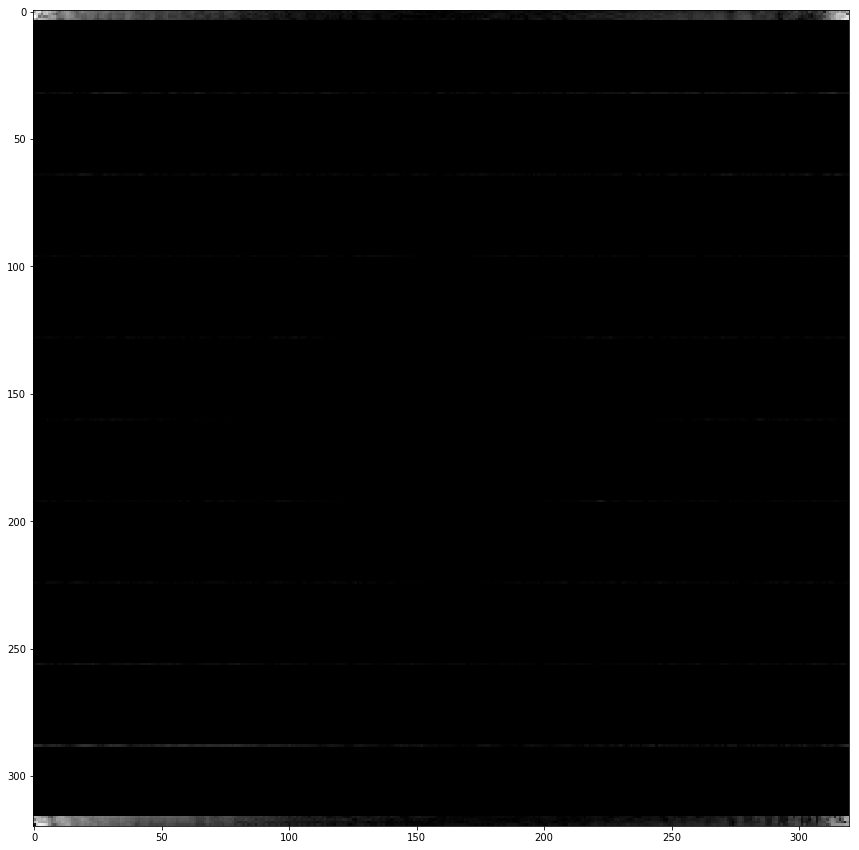

In [92]:
simulated_kspace_cartesian_x = simulated_kspace_cartesian * cartesian_usmask_x.reshape((1, 1, 320, 320, 1)).to(device)
print(simulated_kspace_cartesian_x.shape)

plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_x)[0, 0])))
plt.show()

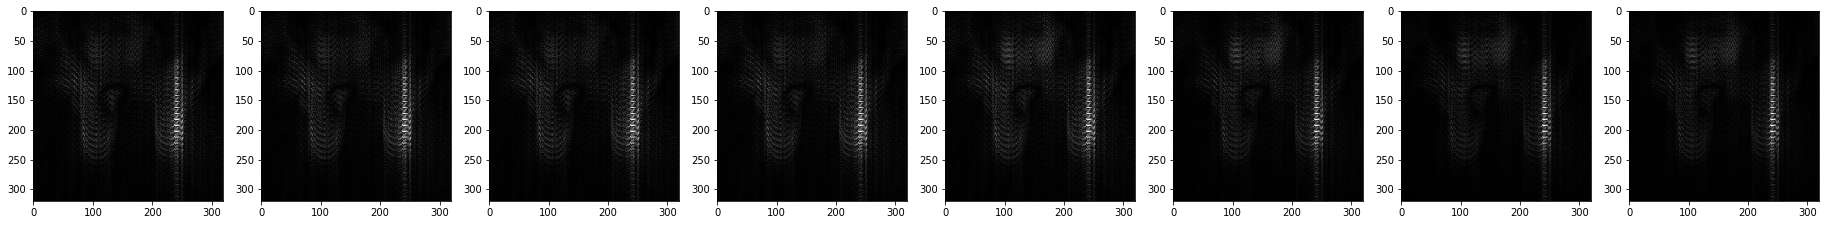

(22, 320, 320)


In [94]:
Cartesian_model = CartesianModel()
zerofilled_x = Cartesian_model.backward(y= simulated_kspace_cartesian_x / density_x.reshape((1, 1, 320, 320, 1)).to(device), coil_sensitivities= smap_loaded)
zerofilled_x = torch2numpy(zerofilled_x.squeeze(), complexdim= 1)

plotcoil(zerofilled_x)

print(zerofilled_x.shape)

(22,)


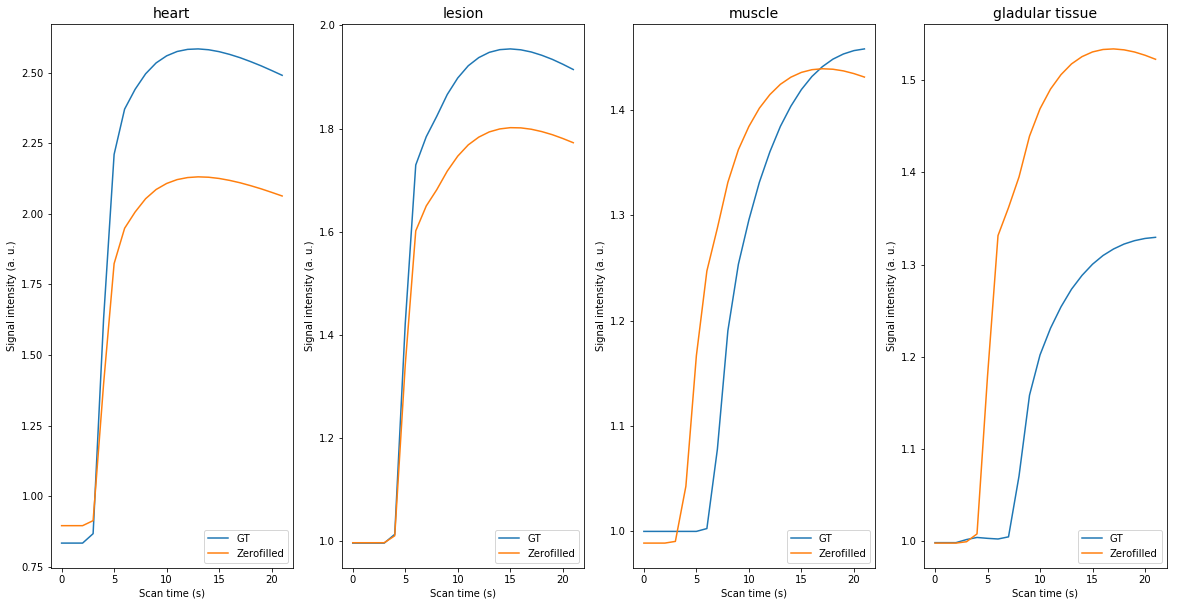

In [95]:
plotcurves(x_hat = np.abs(zerofilled_x[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Zerofilled', 'GT'], 
           normalize = True)

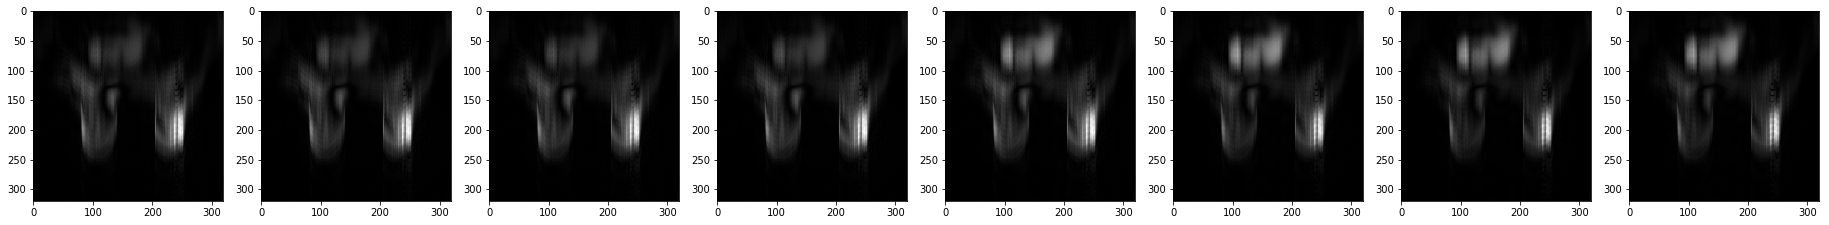

(22, 320, 320)


In [98]:
#no decomp
zerofilled_x = Cartesian_model.backward(y= simulated_kspace_cartesian_x, coil_sensitivities= smap_loaded)
zerofilled_x = torch2numpy(zerofilled_x.squeeze(), complexdim= 1)

plotcoil(zerofilled_x)

print(zerofilled_x.shape)

(22,)


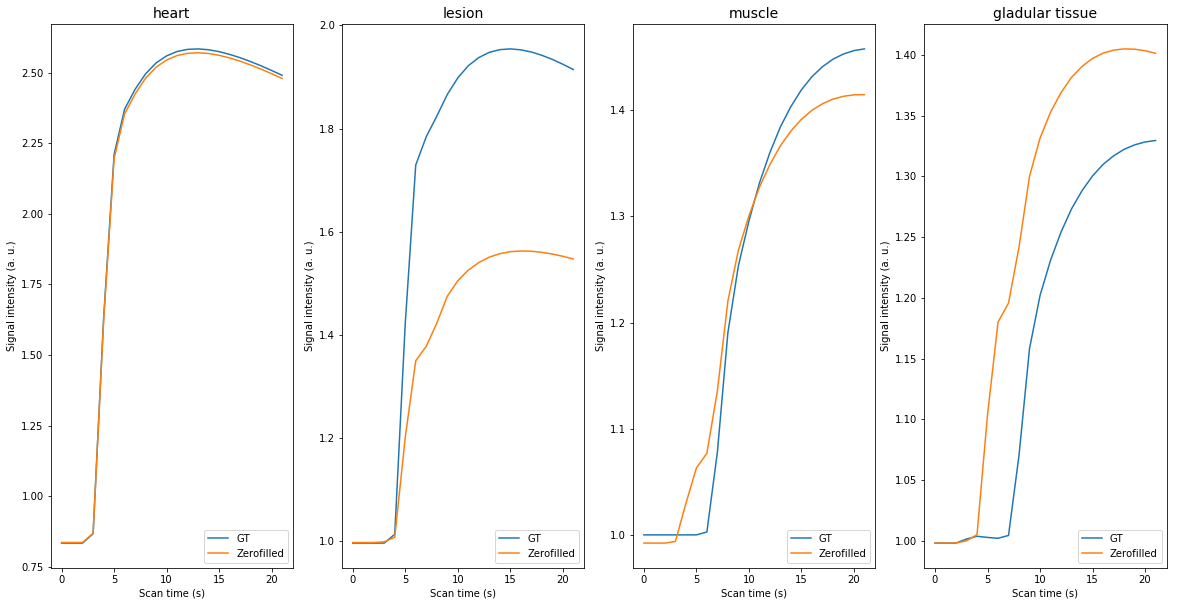

In [99]:
plotcurves(x_hat = np.abs(zerofilled_x[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Zerofilled', 'GT'], 
           normalize = True)

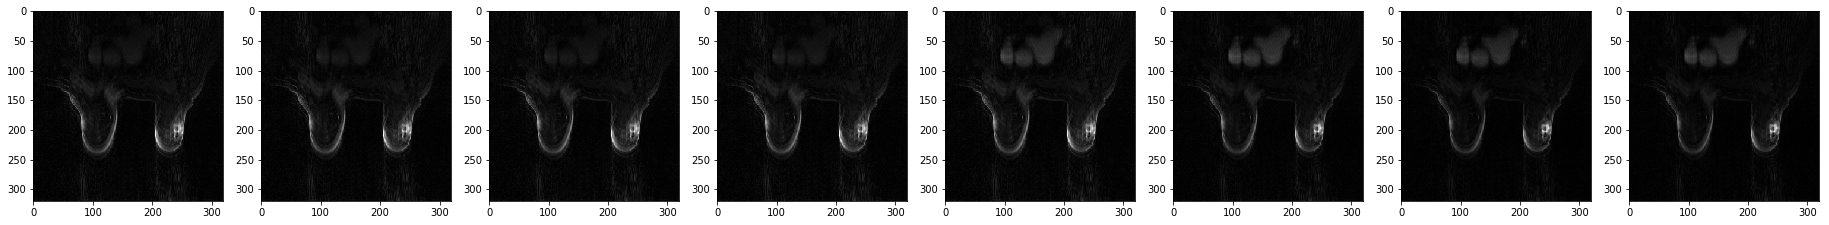

(22,)


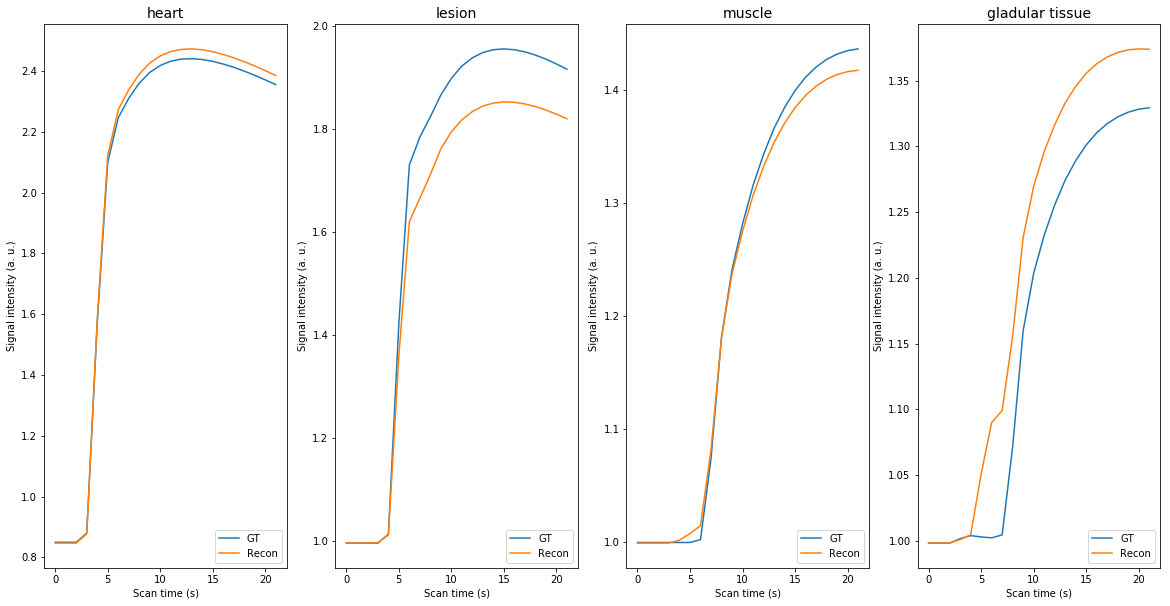

In [96]:
cartesian_recon_x, zerofilled_x = CartesianRecon(kspace= simulated_kspace_cartesian_x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask_x.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 128, verbose = False)

plotcoil(torch2numpy(cartesian_recon_x, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon_x, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

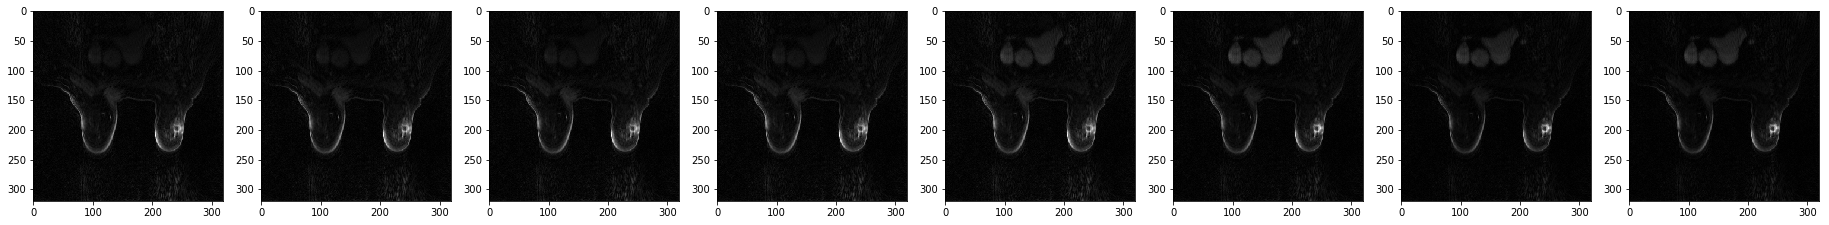

(22,)


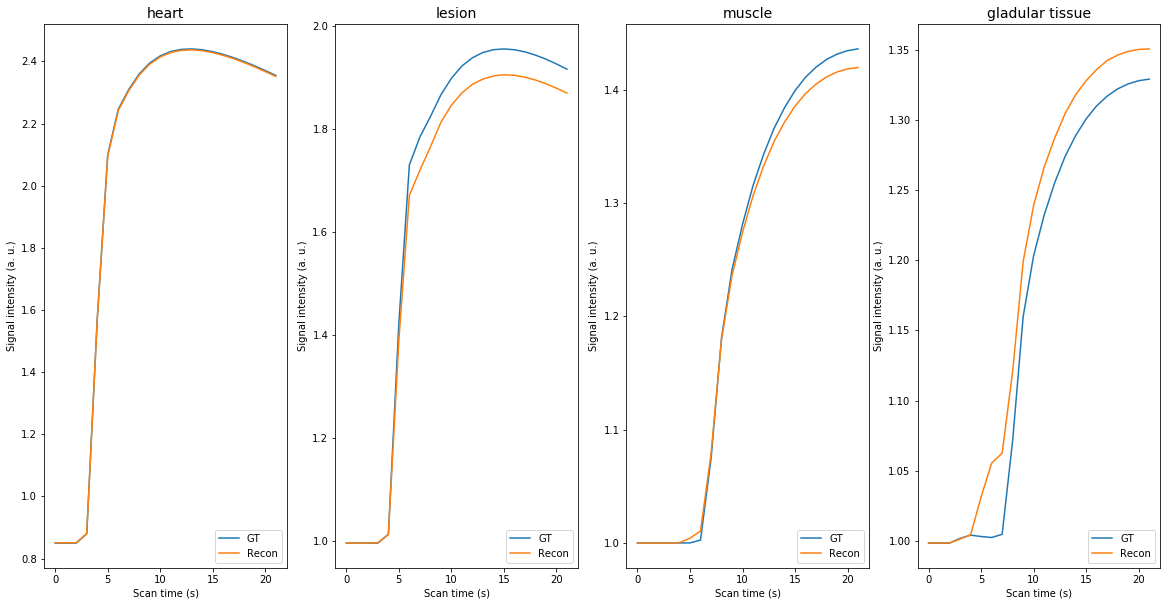

In [97]:
cartesian_recon_x, zerofilled_x = CartesianRecon(kspace= simulated_kspace_cartesian_x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask_x.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 640, verbose = False)

plotcoil(torch2numpy(cartesian_recon_x, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon_x, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)